# Notebook for replicating the analyses in "Arkansas business and individual income tax reform"
### Richard W. Evans, November 2024
This notebook replicates the analyses by [Richard W. Evans](https://sites.google.com/site/rickecon) (@rickecon) in the November 2024 article, "[Arkansas business and individual income tax reform]()".

A GitHub repository with all the data, images, and code from these analyses, with a corresponding Jupyter notebook ([`AR_IndivBusTax.ipynb`](https://github.com/OpenSourceEcon/AR-IndivBusTax/blob/main/AR_IndivBusTax.ipynb)) that can be run from your local machine, is available here (https://github.com/OpenSourceEcon/AR-IndivBusTax).

A Google Colab version of this notebook that can be run from your browser in the cloud is available at [this link](https://colab.research.google.com/drive/1MLDJtMhEMF11oFazq3-JlHRYWhynOIqg?usp=sharing).

## 1. Introduction
Before opening and running this notebook, make sure that you have downloaded or cloned the [`AR-IndivBusTax`](https://github.com/OpenSourceEcon/AR-IndivBusTax) repository (https://github.com/OpenSourceEcon/AR-IndivBusTax) and created and activated the associated conda environment `ar-indivbustax-dev` in the `environment.yml` file. You can also run this notebook easily in the cloud by going to this [Google Colab version](https://colab.research.google.com/drive/1MLDJtMhEMF11oFazq3-JlHRYWhynOIqg?usp=sharing) of this notebook.

In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import (
    ColumnDataSource, Title, Label, LabelSet, Legend, LegendItem,
    CategoricalColorMapper, ColorBar, HoverTool, NumeralTickFormatter,
    GeoJSONDataSource, FactorRange
)
from bokeh.models.tickers import SingleIntervalTicker
from bokeh.transform import factor_cmap
from bokeh.sampledata.us_states import data as states
from bokeh.transform import cumsum
from bokeh.palettes import Category20c

import ccc
import taxcalc as tc
import requests
import random
import json

import plotly.express as px

from fiscalsim_us.model_api import *
from fiscalsim_us import Simulation
from policyengine_core.reforms import Reform
from policyengine_core.periods import instant

## 2. Create Figures 1 and 2

### 2.1. Create Figure 1, US State Employment Income Tax Systems as of July 2024

In [2]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data')
image_dir = os.path.join(cur_dir, 'images')

Create the data for state tax type.

In [3]:
# Create a DataFrame of states and their tax types as of July, 2024. For
# a summary of current tax brackets and rates see Andrey Yushkov, "State
# Individual Income Tax Rates and Brackets, 2024", Tax Foundation, Feb. 20,
# 2024. https://taxfoundation.org/data/all/state/state-income-tax-rates-2024/
# 0 = No state income tax
# 1 = Flat state income tax rate
# 2 = Nearly flat state income tax rates (top tax bracket starts at <= $20,000
#     for married filing jointly)
# 3 = Progressive state income tax rates
state_taxtype_list = [
    ["Alabama", "AL", 2, "5.00%"],  # top income bracket starts at $6k
    ["Alaska", "AK", 0, "0.00%"],
    ["Arizona", "AZ", 1, "2.50%"],
    ["Arkansas", "AR", 3, "3.90%"],  # top income bracket starts at $25k
    ["California", "CA", 3, "13.30%"],  # top income bracket starts at $1m
    ["Colorado", "CO", 1, "4.40%"],
    ["Connecticut", "CT", 3, "6.99%"],  # top income bracket starts at $1m
    ["Delaware", "DE", 3, "6.60%"],  # top income bracket starts at $60k
    ["District of Columbia", "DC", 3, "10.75%"],  # top income bracket starts at $1m
    ["Florida", "FL", 0, "0.00%"],
    ["Georgia", "GA", 1, "5.49%"],
    ["Hawaii", "HI", 3, "11.00%"],  # top income bracket starts at $400k
    ["Idaho", "ID", 2, "5.695%"],  # top income bracket starts at $5k
    ["Illinois", "IL", 1, "4.95%"],
    ["Indiana", "IN", 1, "3.05%"],
    ["Iowa", "IA", 2, "5.70%"],  # top income bracket starts at $62,100
    ["Kansas", "KS", 3, "5.70%"],  # top income bracket starts at $60k
    ["Kentucky", "KY", 1, "4.00%"],
    ["Louisiana", "LA", 3, "4.25%"],  # top income bracket starts at $50k net income
    ["Maine", "ME", 3, "7.15%"],  # top income bracket starts at $123,250
    ["Maryland", "MD", 3, "5.75%"],  # top income bracket starts at $300k
    ["Massachusetts", "MA", 3, "9.00%"],  # top income bracket starts at $1m
    ["Michigan", "MI", 1, "4.25%"],
    ["Minnesota", "MN", 3, "9.85%"],  # top income bracket starts at $321,450
    ["Mississippi", "MS", 2, "4.70%"],  # top income bracket starts at $10k
    ["Missouri", "MO", 2, "4.80%"],  # top income bracket starts at $8,449
    ["Montana", "MT", 3, "5.90%"],  # top income bracket starts at $41k
    ["Nebraska", "NE", 3, "5.84%"],  # top income bracket starts at $71,460
    ["Nevada", "NV", 0, "0.00%"],
    ["New Hampshire", "NH", 0, "0.00%"],
    ["New Jersey", "NJ", 3, "10.75%"],  # top income bracket starts at $1m
    ["New Mexico", "NM", 3, "5.90%"],  # top income bracket starts at $315k
    ["New York", "NY", 3, "10.90%"],  # top income bracket starts at $25m
    ["North Carolina", "NC", 1, "4.50%"],
    ["North Dakota", "ND", 3, "2.50%"],  # top income bracket starts at $275,100
    ["Ohio", "OH", 3, "3.50%"],  # top income bracket starts at $92,150
    ["Oklahoma", "OK", 2, "4.75%"],  # top income bracket starts at $12.2k
    ["Oregon", "OR", 3, "9.90%"],  # top income bracket starts at $250k
    ["Pennsylvania", "PA", 1, "3.07%"],
    ["Rhode Island", "RI", 3, "5.99%"],  # top income bracket starts at $176,050
    ["South Carolina", "SC", 3, "6.20%"],  # top income bracket starts at $46,530
    ["South Dakota", "SD", 0, "0.00%"],
    ["Tennessee", "TN", 0, "0.00%"],
    ["Texas", "TX", 0, "0.00%"],
    ["Utah", "UT", 1, "4.65%"],
    ["Virginia", "VA", 2, "5.75%"],  # top income bracket starts at $17,000
    ["Vermont", "VT", 3, "8.75%"],  # top income bracket starts at $279,450
    ["Washington", "WA", 0, "0.00%"],
    ["West Virginia", "WV", 3, "5.12%"],  # top income bracket starts at $60k
    ["Wisconsin", "WI", 3, "7.65%"],  # top income bracket starts at $420,420
    ["Wyoming", "WY", 0, "0.00%"],
]
state_taxtype_df = pd.DataFrame(
    state_taxtype_list, columns=["State", "Abbrev", "TaxType", "TopRate"]
)
state_taxtype_df["TaxType_str"] = ""
state_taxtype_df["TaxType_str"][state_taxtype_df["TaxType"]==0] = \
    "No state labor income tax"
state_taxtype_df["TaxType_str"][state_taxtype_df["TaxType"]==1] = \
    "Flat state income tax rate"
state_taxtype_df["TaxType_str"][state_taxtype_df["TaxType"]==2] = \
    "Nearly flat state income tax rates"
state_taxtype_df["TaxType_str"][state_taxtype_df["TaxType"]==3] = \
    "Progressive state income tax rates"
state_taxtype_df["TaxType_str_short"] = ""
state_taxtype_df["TaxType_str_short"][state_taxtype_df["TaxType"]==0] = \
    "No income tax"
state_taxtype_df["TaxType_str_short"][state_taxtype_df["TaxType"]==1] = \
    "Flat income tax rate"
state_taxtype_df["TaxType_str_short"][state_taxtype_df["TaxType"]==2] = \
    "Nearly flat income tax rates"
state_taxtype_df["TaxType_str_short"][state_taxtype_df["TaxType"]==3] = \
    "Progressive income tax rates"
state_taxtype_df["fill_color"] = ""
state_taxtype_df["fill_color"][state_taxtype_df["TaxType"]==0] = "#D8D3D3"
state_taxtype_df["fill_color"][state_taxtype_df["TaxType"]==1] = "red"
state_taxtype_df["fill_color"][state_taxtype_df["TaxType"]==2] = "purple"
state_taxtype_df["fill_color"][state_taxtype_df["TaxType"]==3] = "blue"
state_taxtype_df["label_color"] = "black"
state_taxtype_df["label_color"][state_taxtype_df["TaxType"]==3] = "white"

# Sort alphabetically by full state name
state_taxtype_df.sort_values("State", inplace=True, ignore_index=True)

# Create sub-DataFrames for each tax type
no_tax_states_df = \
    state_taxtype_df[state_taxtype_df["TaxType"]==0].reset_index(drop=True)
flat_tax_states_df = \
    state_taxtype_df[state_taxtype_df["TaxType"]==1].reset_index(drop=True)
nflat_tax_states_df = \
    state_taxtype_df[state_taxtype_df["TaxType"]==2].reset_index(drop=True)
prog_tax_states_df = \
    state_taxtype_df[state_taxtype_df["TaxType"]==3].reset_index(drop=True)
print(state_taxtype_df.groupby("TaxType").count())

# Save state_taxtype_df as .csv
state_taxtype_df.to_csv('./data/fig1_state_taxtype_2024.csv', index=False)
state_taxtype_df

         State  Abbrev  TopRate  TaxType_str  TaxType_str_short  fill_color  \
TaxType                                                                       
0            9       9        9            9                  9           9   
1           10      10       10           10                 10          10   
2            7       7        7            7                  7           7   
3           25      25       25           25                 25          25   

         label_color  
TaxType               
0                  9  
1                 10  
2                  7  
3                 25  


State Abbrev  TaxType TopRate  \
0                Alabama     AL        2   5.00%   
1                 Alaska     AK        0   0.00%   
2                Arizona     AZ        1   2.50%   
3               Arkansas     AR        3   3.90%   
4             California     CA        3  13.30%   
5               Colorado     CO        1   4.40%   
6            Connecticut     CT        3   6.99%   
7               Delaware     DE        3   6.60%   
8   District of Columbia     DC        3  10.75%   
9                Florida     FL        0   0.00%   
10               Georgia     GA        1   5.49%   
11                Hawaii     HI        3  11.00%   
12                 Idaho     ID        2  5.695%   
13              Illinois     IL        1   4.95%   
14               Indiana     IN        1   3.05%   
15                  Iowa     IA        2   5.70%   
16                Kansas     KS        3   5.70%   
17              Kentucky     KY        1   4.00%   
18             Louisiana     LA        3   4.25%   
19                 Maine     ME        3   7.15%   
20              Maryland     MD        3   5.75%   
21         Massachusetts     MA        3   9.00%   
22              Michigan     MI        1   4.25%   
23             Minnesota     MN        3   9.85%   
24           Mississippi     MS        2   4.70%   
25              Missouri     MO        2   4.80%   
26               Montana     MT        3   5.90%   
27              Nebraska     NE        3   5.84%   
28                Nevada     NV        0   0.00%   
29         New Hampshire     NH        0   0.00%   
30            New Jersey     NJ        3  10.75%   
31            New Mexico     NM        3   5.90%   
32              New York     NY        3  10.90%   
33        North Carolina     NC        1   4.50%   
34          North Dakota     ND        3   2.50%   
35                  Ohio     OH        3   3.50%   
36              Oklahoma     OK        2   4.75%   
37                Oregon     OR        3   9.90%   
38          Pennsylvania     PA        1   3.07%   
39          Rhode Island     RI        3   5.99%   
40        South Carolina     SC        3   6.20%   
41          South Dakota     SD        0   0.00%   
42             Tennessee     TN        0   0.00%   
43                 Texas     TX        0   0.00%   
44                  Utah     UT        1   4.65%   
45               Vermont     VT        3   8.75%   
46              Virginia     VA        2   5.75%   
47            Washington     WA        0   0.00%   
48         West Virginia     WV        3   5.12%   
49             Wisconsin     WI        3   7.65%   
50               Wyoming     WY        0   0.00%   

                           TaxType_str             TaxType_str_short  \
0   Nearly flat state income tax rates  Nearly flat income tax rates   
1            No state labor income tax                 No income tax   
2           Flat state income tax rate          Flat income tax rate   
3   Progressive state income tax rates  Progressive income tax rates   
4   Progressive state income tax rates  Progressive income tax rates   
5           Flat state income tax rate          Flat income tax rate   
6   Progressive state income tax rates  Progressive income tax rates   
7   Progressive state income tax rates  Progressive income tax rates   
8   Progressive state income tax rates  Progressive income tax rates   
9            No state labor income tax                 No income tax   
10          Flat state income tax rate          Flat income tax rate   
11  Progressive state income tax rates  Progressive income tax rates   
12  Nearly flat state income tax rates  Nearly flat income tax rates   
13          Flat state income tax rate          Flat income tax rate   
14          Flat state income tax rate          Flat income tax rate   
15  Nearly flat state income tax rates  Nearly flat income tax rates   
16  Progressive state income tax rates  Progressive income tax rates   
17          Flat s

In [4]:
# Print the no tax states
no_tax_states_df

State Abbrev  TaxType TopRate                TaxType_str  \
0         Alaska     AK        0   0.00%  No state labor income tax   
1        Florida     FL        0   0.00%  No state labor income tax   
2         Nevada     NV        0   0.00%  No state labor income tax   
3  New Hampshire     NH        0   0.00%  No state labor income tax   
4   South Dakota     SD        0   0.00%  No state labor income tax   
5      Tennessee     TN        0   0.00%  No state labor income tax   
6          Texas     TX        0   0.00%  No state labor income tax   
7     Washington     WA        0   0.00%  No state labor income tax   
8        Wyoming     WY        0   0.00%  No state labor income tax   

  TaxType_str_short fill_color label_color  
0     No income tax    #D8D3D3       black  
1     No income tax    #D8D3D3       black  
2     No income tax    #D8D3D3       black  
3     No income tax    #D8D3D3       black  
4     No income tax    #D8D3D3       black  
5     No income tax    #D8D3D3       black  
6     No income tax    #D8D3D3       black  
7     No income tax    #D8D3D3       black  
8     No income tax    #D8D3D3       black

In [5]:
# Print the flat tax states
flat_tax_states_df

State Abbrev  TaxType TopRate                 TaxType_str  \
0         Arizona     AZ        1   2.50%  Flat state income tax rate   
1        Colorado     CO        1   4.40%  Flat state income tax rate   
2         Georgia     GA        1   5.49%  Flat state income tax rate   
3        Illinois     IL        1   4.95%  Flat state income tax rate   
4         Indiana     IN        1   3.05%  Flat state income tax rate   
5        Kentucky     KY        1   4.00%  Flat state income tax rate   
6        Michigan     MI        1   4.25%  Flat state income tax rate   
7  North Carolina     NC        1   4.50%  Flat state income tax rate   
8    Pennsylvania     PA        1   3.07%  Flat state income tax rate   
9            Utah     UT        1   4.65%  Flat state income tax rate   

      TaxType_str_short fill_color label_color  
0  Flat income tax rate        red       black  
1  Flat income tax rate        red       black  
2  Flat income tax rate        red       black  
3  Flat income tax rate        red       black  
4  Flat income tax rate        red       black  
5  Flat income tax rate        red       black  
6  Flat income tax rate        red       black  
7  Flat income tax rate        red       black  
8  Flat income tax rate        red       black  
9  Flat income tax rate        red       black

In [6]:
# Print the nearly flat tax states
nflat_tax_states_df

State Abbrev  TaxType TopRate                         TaxType_str  \
0      Alabama     AL        2   5.00%  Nearly flat state income tax rates   
1        Idaho     ID        2  5.695%  Nearly flat state income tax rates   
2         Iowa     IA        2   5.70%  Nearly flat state income tax rates   
3  Mississippi     MS        2   4.70%  Nearly flat state income tax rates   
4     Missouri     MO        2   4.80%  Nearly flat state income tax rates   
5     Oklahoma     OK        2   4.75%  Nearly flat state income tax rates   
6     Virginia     VA        2   5.75%  Nearly flat state income tax rates   

              TaxType_str_short fill_color label_color  
0  Nearly flat income tax rates     purple       black  
1  Nearly flat income tax rates     purple       black  
2  Nearly flat income tax rates     purple       black  
3  Nearly flat income tax rates     purple       black  
4  Nearly flat income tax rates     purple       black  
5  Nearly flat income tax rates     purple       black  
6  Nearly flat income tax rates     purple       black

In [7]:
# Print the progressive tax states
prog_tax_states_df

State Abbrev  TaxType TopRate  \
0               Arkansas     AR        3   3.90%   
1             California     CA        3  13.30%   
2            Connecticut     CT        3   6.99%   
3               Delaware     DE        3   6.60%   
4   District of Columbia     DC        3  10.75%   
5                 Hawaii     HI        3  11.00%   
6                 Kansas     KS        3   5.70%   
7              Louisiana     LA        3   4.25%   
8                  Maine     ME        3   7.15%   
9               Maryland     MD        3   5.75%   
10         Massachusetts     MA        3   9.00%   
11             Minnesota     MN        3   9.85%   
12               Montana     MT        3   5.90%   
13              Nebraska     NE        3   5.84%   
14            New Jersey     NJ        3  10.75%   
15            New Mexico     NM        3   5.90%   
16              New York     NY        3  10.90%   
17          North Dakota     ND        3   2.50%   
18                  Ohio     OH        3   3.50%   
19                Oregon     OR        3   9.90%   
20          Rhode Island     RI        3   5.99%   
21        South Carolina     SC        3   6.20%   
22               Vermont     VT        3   8.75%   
23         West Virginia     WV        3   5.12%   
24             Wisconsin     WI        3   7.65%   

                           TaxType_str             TaxType_str_short  \
0   Progressive state income tax rates  Progressive income tax rates   
1   Progressive state income tax rates  Progressive income tax rates   
2   Progressive state income tax rates  Progressive income tax rates   
3   Progressive state income tax rates  Progressive income tax rates   
4   Progressive state income tax rates  Progressive income tax rates   
5   Progressive state income tax rates  Progressive income tax rates   
6   Progressive state income tax rates  Progressive income tax rates   
7   Progressive state income tax rates  Progressive income tax rates   
8   Progressive state income tax rates  Progressive income tax rates   
9   Progressive state income tax rates  Progressive income tax rates   
10  Progressive state income tax rates  Progressive income tax rates   
11  Progressive state income tax rates  Progressive income tax rates   
12  Progressive state income tax rates  Progressive income tax rates   
13  Progressive state income tax rates  Progressive income tax rates   
14  Progressive state income tax rates  Progressive income tax rates   
15  Progressive state income tax rates  Progressive income tax rates   
16  Progressive state income tax rates  Progressive income tax rates   
17  Progressive state income tax rates  Progressive income tax rates   
18  Progressive state income tax rates  Progressive income tax rates   
19  Progressive state income tax rates  Progressive income tax rates   
20  Progressive state income tax rates  Progressive income tax rates   
21  Progressive state income tax rates  Progressive income tax rates   
22  Progressive state income tax rates  Progressive income tax rates   
23  Progressive state income tax rates  Progressive income tax rates   
24  Progressive state income tax rates  Progressive income tax rates   

   fill_color label_color  
0        blue       white  
1        blue       white  
2        blue       white  
3        blue       white  
4        blue       white  
5        blue       white  
6        blue       white  
7        blue       white  
8        blue       white  
9        blue       white  
10       blue       white  
11       blue       white  
12       blue       white  
13       blue       white  
14       blue       white  
15       blue       white  
16       blue       white  
17       blue       white  
18       blue       white  
19       blue       white  
20       blue       white  
21       blue       white  
22       blue       white  
23       blue       white  
24       blue       white

Create Table 2. Top 20 states with lowest state top marginal employment income tax rate as of July 2024

In [21]:
sorted_state_taxtype_df = state_taxtype_df.sort_values("TopRate", ascending=True)
sorted_state_taxtype_df

State Abbrev  TaxType TopRate  \
50               Wyoming     WY        0   0.00%   
29         New Hampshire     NH        0   0.00%   
42             Tennessee     TN        0   0.00%   
43                 Texas     TX        0   0.00%   
9                Florida     FL        0   0.00%   
47            Washington     WA        0   0.00%   
41          South Dakota     SD        0   0.00%   
28                Nevada     NV        0   0.00%   
1                 Alaska     AK        0   0.00%   
8   District of Columbia     DC        3  10.75%   
30            New Jersey     NJ        3  10.75%   
32              New York     NY        3  10.90%   
11                Hawaii     HI        3  11.00%   
4             California     CA        3  13.30%   
2                Arizona     AZ        1   2.50%   
34          North Dakota     ND        3   2.50%   
14               Indiana     IN        1   3.05%   
38          Pennsylvania     PA        1   3.07%   
35                  Ohio     OH        3   3.50%   
3               Arkansas     AR        3   3.90%   
17              Kentucky     KY        1   4.00%   
22              Michigan     MI        1   4.25%   
18             Louisiana     LA        3   4.25%   
5               Colorado     CO        1   4.40%   
33        North Carolina     NC        1   4.50%   
44                  Utah     UT        1   4.65%   
24           Mississippi     MS        2   4.70%   
36              Oklahoma     OK        2   4.75%   
25              Missouri     MO        2   4.80%   
13              Illinois     IL        1   4.95%   
0                Alabama     AL        2   5.00%   
48         West Virginia     WV        3   5.12%   
10               Georgia     GA        1   5.49%   
12                 Idaho     ID        2  5.695%   
16                Kansas     KS        3   5.70%   
15                  Iowa     IA        2   5.70%   
46              Virginia     VA        2   5.75%   
20              Maryland     MD        3   5.75%   
27              Nebraska     NE        3   5.84%   
26               Montana     MT        3   5.90%   
31            New Mexico     NM        3   5.90%   
39          Rhode Island     RI        3   5.99%   
40        South Carolina     SC        3   6.20%   
7               Delaware     DE        3   6.60%   
6            Connecticut     CT        3   6.99%   
19                 Maine     ME        3   7.15%   
49             Wisconsin     WI        3   7.65%   
45               Vermont     VT        3   8.75%   
21         Massachusetts     MA        3   9.00%   
23             Minnesota     MN        3   9.85%   
37                Oregon     OR        3   9.90%   

                           TaxType_str             TaxType_str_short  \
50           No state labor income tax                 No income tax   
29           No state labor income tax                 No income tax   
42           No state labor income tax                 No income tax   
43           No state labor income tax                 No income tax   
9            No state labor income tax                 No income tax   
47           No state labor income tax                 No income tax   
41           No state labor income tax                 No income tax   
28           No state labor income tax                 No income tax   
1            No state labor income tax                 No income tax   
8   Progressive state income tax rates  Progressive income tax rates   
30  Progressive state income tax rates  Progressive income tax rates   
32  Progressive state income tax rates  Progressive income tax rates   
11  Progressive state income tax rates  Progressive income tax rates   
4   Progressive state income tax rates  Progressive income tax rates   
2           Flat state income tax rate          Flat income tax rate   
34  Progressive state income tax rates  Progressive income tax rates   
14          Flat state income tax rate          Flat income tax rate   
38          Flat s

Create the Bokeh state map figure

In [18]:
fig1_title = "Figure 1. US State Employment Income Tax Systems as of July 2024"
# fig1_title = ""
output_file(
    "./images/fig1_state_taxtype_2024.html", title=fig1_title, mode='inline'
)
output_notebook()

# Download U.S. states shape files from US Census Bureau
# https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html
us_shapefile_path = (
    "https://github.com/OpenSourceEcon/AR-IndivBusTax/raw/main/data/" +
    "cb_2018_us_state_20m/cb_2018_us_state_20m.shp"
)
gdf = gpd.GeoDataFrame.from_file(us_shapefile_path)
gdf_json = gdf.to_json()
gjson = json.loads(gdf_json)

# Remove Puerto Rico from data
del(gjson["features"][7])

# Alaska
# Fix positive longitudes
min_lat_ak = 180  # initial value that will be adjusted
min_abs_lon_ak = 180  # initial value that will be adjusted
coords_list = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_ak = np.minimum(min_lat_ak, point[1])
        if point[0] > 0:
            gjson["features"][24]["geometry"][
                "coordinates"
            ][ind_isl][0][ind_pnt][0] = -180 - (180 - point[0])
        else:
            min_abs_lon_ak = np.minimum(min_abs_lon_ak, -point[0])

# Shrink the size of Alaska relative to its southestern most minimum lattitude
# and longitude
shrink_pct_ak = 0.65
coords_list_ak = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_ak):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] - shrink_pct_ak * (point[0] +
                                                                min_abs_lon_ak)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - shrink_pct_ak * (point[1] -
                                                                min_lat_ak)

# Move Alaska closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-127, 44)
min_lat_ak_new = 44
min_abs_lon_ak_new = 127
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_ak -
                                                min_abs_lon_ak_new)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_ak - min_lat_ak_new)

# Hawaii
list_ind_hi = 47
# Get minimum lattitude and minimum absolute longitude for Hawaii
min_lat_hi = 180  # initial value that will be adjusted
min_abs_lon_hi = 180  # initial value that will be adjusted
coords_list = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_hi = np.minimum(min_lat_hi, point[1])
        min_abs_lon_hi = np.minimum(min_abs_lon_hi, -point[0])
# print("Minimum lattitude for Hawaii is", min_lat_hi)
# print("Minimum absolute longitude for Hawaii is", min_abs_lon_hi)

# Increase the size of Hawaii
incr_pct_hi = 0.4
coords_list_hi = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_hi):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + incr_pct_hi * (point[0] +
                                                              min_abs_lon_hi)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] + incr_pct_hi * (point[1] -
                                                              min_lat_hi)

# Move Hawaii closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-125, 27)
min_lat_hi_new = 27.5
min_abs_lon_hi_new = 124.5
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_hi -
                                                min_abs_lon_hi_new)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_hi - min_lat_hi_new)

# Add a state box around Delaware abbreviation DE
st_list_num = 2
de_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_de = [[
    [-75.4, 38.8],
    [-72.4, 38.3],
    [-72.4, 38.9],
    [-70.2, 38.9],
    [-70.2, 37.7],
    [-72.4, 37.7],
    [-72.4, 38.3]
]]
de_coord_list.append(new_box_de)
gjson["features"][st_list_num]["geometry"]["coordinates"] = de_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Washington, DC (District of Columbia) abbreviation DC
st_list_num = 35
dc_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_dc = [[
    [-77.0, 38.9],
    [-73.3, 35.5],
    [-73.3, 36.1],
    [-71.1, 36.1],
    [-71.1, 34.9],
    [-73.3, 34.9],
    [-73.3, 35.5]
]]
dc_coord_list.append(new_box_dc)
gjson["features"][st_list_num]["geometry"]["coordinates"] = dc_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Massachusetts abbreviation MD
st_list_num = 0
md_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_md = [[
    [-76.8, 39.3],
    [-72.7, 37.0],
    [-72.7, 37.6],
    [-70.5, 37.6],
    [-70.5, 36.4],
    [-72.7, 36.4],
    [-72.7, 37.0]
]]
md_coord_list.append(new_box_md)
gjson["features"][st_list_num]["geometry"]["coordinates"] = md_coord_list

# Add a state box around Massachusetts abbreviation MA
st_list_num = 29
ma_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ma = [[
    [-71.7, 42.2],
    [-68.5, 42.2],
    [-68.5, 42.8],
    [-66.3, 42.8],
    [-66.3, 41.6],
    [-68.5, 41.6],
    [-68.5, 42.2]
]]
ma_coord_list.append(new_box_ma)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ma_coord_list

# Add a state box around New Jersey abbreviation NJ
st_list_num = 34
nj_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_nj = [[
    [-74.4, 40.1],
    [-72.0, 39.7],
    [-72.0, 40.3],
    [-69.8, 40.3],
    [-69.8, 39.1],
    [-72.0, 39.1],
    [-72.0, 39.7]
]]
nj_coord_list.append(new_box_nj)
gjson["features"][st_list_num]["geometry"]["coordinates"] = nj_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Rhode Island abbreviation RI
st_list_num = 50
ri_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ri = [[
    [-71.5, 41.7],
    [-69.5, 40.4],
    [-69.5, 41.0],
    [-67.3, 41.0],
    [-67.3, 39.8],
    [-69.5, 39.8],
    [-69.5, 40.4]
]]
ri_coord_list.append(new_box_ri)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ri_coord_list

# Merge the state tax type data into gjson for each state
state_taxtype_df
for ind_st, state in enumerate(gjson["features"]):
    st_abbrev = state["properties"]["STUSPS"]
    state["properties"]["tax_type"] = state_taxtype_df[
        state_taxtype_df["Abbrev"]==st_abbrev
    ]["TaxType_str_short"].iloc[0]
    state["properties"]["top_rate"] = state_taxtype_df[
        state_taxtype_df["Abbrev"]==st_abbrev
    ]["TopRate"].iloc[0]

tax_type_labels = [
    'No income tax', 'Flat income tax rate', 'Nearly flat income tax rates',
    'Progressive income tax rates'
]
tax_type_colors = ["white", "red", "purple", "blue"]

source_shapes = {}
for category in tax_type_labels:
    source_shapes[category] = {"type": "FeatureCollection", "features": []}

for item in gjson["features"]:
    source_shapes[item["properties"]["tax_type"]]['features'].append(item)

TOOLS = "pan, box_zoom, wheel_zoom, hover, save, reset, help"

fig1 = figure(
    title=fig1_title,
    height=500,
    width=950,
    tools=TOOLS,
    min_border = 0,
    x_axis_location = None, y_axis_location = None,
    toolbar_location="right"
)
fig1.toolbar.logo = None
fig1.grid.grid_line_color = None

cmap = CategoricalColorMapper(
    palette=tax_type_colors, factors=tax_type_labels
)
for category in tax_type_labels:
    source_shape_1 = GeoJSONDataSource(
        geojson = json.dumps(source_shapes[category])
    )
    fig1.patches(
        'xs', 'ys', source=source_shape_1, fill_alpha=0.7,
        fill_color = {'field': 'tax_type', 'transform': cmap},
        line_color ='black', line_width=1.0, line_alpha=0.3,
        hover_line_color="black", hover_line_width=3.0, legend_label=category)

    hover = fig1.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("State", "@NAME"),
        ("Tax type", "@tax_type"),
        ("Top rate", "@top_rate")
    ]

# Add 2-letter state abbreviation labels. See Bokeh documentation for labels at
# https://docs.bokeh.org/en/latest/docs/user_guide/basic/annotations.html.
label_lon_lat =[
    ["AL",  -87.40, 32.10],
    ["AK", -135.00, 48.30],
    ["AZ", -112.40, 34.00],
    ["AR",  -93.20, 34.30],
    ["CA", -121.00, 37.00],
    ["CO", -106.50, 38.50],
    ["CT",  -73.40, 41.25],
    ["DE",  -72.10, 37.80],
    ["DC",  -73.00, 35.00],
    ["FL",  -82.40, 28.00],
    ["GA",  -84.20, 32.20],
    ["HI", -126.00, 28.00],
    ["ID", -115.00, 43.00],
    ["IL",  -89.60, 39.50],
    ["IN",  -86.90, 39.60],
    ["IA",  -94.40, 41.60],
    ["KS",  -99.50, 38.00],
    ["KY",  -86.00, 37.00],
    ["LA",  -93.00, 30.20],
    ["ME",  -70.00, 44.50],
    ["MD",  -72.40, 36.50],
    ["MA",  -68.20, 41.80],
    ["MI",  -85.40, 42.70],
    ["MN",  -95.30, 45.50],
    ["MS",  -90.60, 32.10],
    ["MO",  -93.50, 38.00],
    ["MT", -110.50, 46.50],
    ["NE", -100.50, 41.00],
    ["NV", -118.00, 39.00],
    ["NH",  -72.45, 42.70],
    ["NM", -107.00, 34.00],
    ["NJ",  -71.60, 39.30],
    ["NY",  -76.00, 42.50],
    ["NC",  -79.20, 35.00],
    ["ND", -101.50, 46.80],
    ["OH",  -83.80, 39.90],
    ["OK",  -98.00, 35.00],
    ["OR", -121.50, 43.50],
    ["PA",  -78.50, 40.40],
    ["RI",  -69.00, 40.00],
    ["SC",  -81.50, 33.30],
    ["SD", -101.00, 44.00],
    ["TN",  -87.10, 35.40],
    ["TX", -100.00, 31.00],
    ["UT", -112.50, 39.00],
    ["VT",  -73.20, 44.10],
    ["VA",  -79.00, 37.10],
    ["WA", -121.00, 47.00],
    ["WV",  -81.90, 38.00],
    ["WI",  -90.40, 44.00],
    ["WY", -108.50, 42.50]
]
# Add text color element to each state in list based on tax type
for i, state in enumerate(label_lon_lat):
    label_lon_lat[i].append(
        state_taxtype_df[
            state_taxtype_df["Abbrev"]==state[0]
        ]["label_color"].iloc[0]
    )
label_abbrev = [state[0] for state in label_lon_lat]
label_lon = [state[1] for state in label_lon_lat]
label_lat = [state[2] for state in label_lon_lat]
label_color = [state[3] for state in label_lon_lat]
state_cds = ColumnDataSource(data=dict(
    lon=label_lon,
    lat=label_lat,
    abbrev=label_abbrev,
    txtcolor=label_color
))

state_labels = LabelSet(
    x='lon', y='lat', text='abbrev', text_font_size="8pt",
    text_color='txtcolor', text_font_style="bold", x_offset=0, y_offset=0,
    source=state_cds
)

fig1.add_layout(state_labels)

# Legend properties
fig1.legend.click_policy = 'mute'
fig1.legend.location = "center_left"

note_text_list1 = [
    (
        '  Source: Richard W. Evans (@RickEcon), updated Nov. 14, 2024. We ' +
        'define a state as having "Nearly flat income tax rates" if it has ' +
        'multiple'
    ),
    (
        '      tax brackets with differing marginal tax rates and if the ' +
        'minimum income in the top bracket for household filers of status ' +
        '"Married filing'
    ),
    (
        '      jointly" is less than $20k. Data come from Tax Foundation, ' +
        'Yushkov (2024) and state legislative updates for Arkansas, Idaho, ' +
        'South'
    ),
    (
        '      Carolina, and Louisiana.'
    )
]
for note_text in note_text_list1:
    caption = Title(
        text=note_text, align='left', text_font_size='11pt',
        text_font_style='italic',
        text_color='#434244',
        # text_font='Open Sans'
    )
    fig1.add_layout(caption, 'below')

show(fig1)

Loading BokehJS ...

### 2.2. Create Figure 2, Top state corporate income tax rates in southeast states

In [9]:
# Create a DataFrame of states and their corporate income tax types as of
# January 1, 2024. For a summary of current tax brackets and rates see
# Katherine Loughead, "State Corporate Income Tax Rates and Brackets, 2024",
# Tax Foundation, Jan. 23, 2024.
# https://taxfoundation.org/data/all/state/state-corporate-income-tax-rates-brackets-2024/
# 0 = No state corporate income tax
# 1 = Flat state corporate income tax rate
# 2 = Nearly flat state corporate income tax rates (top corporate income tax
#     bracket starts at <= $60,000)
# 3 = Progressive state corporate income tax rates
state_corptaxtype_list = [
    ["Alabama", "AL", 1, "6.50%"],
    ["Alaska", "AK", 3, "9.40%"],  # top income bracket starts at $222k
    ["Arizona", "AZ", 1, "4.90%"],
    ["Arkansas", "AR", 2, "4.30%"],  # top income bracket starts at $11k
    ["California", "CA", 1, "8.84%"],
    ["Colorado", "CO", 1, "4.40%"],
    ["Connecticut", "CT", 3, "17.50%"],  # top income bracket starts at $100m
    ["Delaware", "DE", 1, "8.70%"],
    ["District of Columbia", "DC", 1, "8.25%"],
    ["Florida", "FL", 2, "5.50%"],  # top income bracket starts at $50k
    ["Georgia", "GA", 1, "5.75%"],
    ["Hawaii", "HI", 3, "6.40%"],  # top income bracket starts at $100k
    ["Idaho", "ID", 1, "5.80%"],
    ["Illinois", "IL", 1, "9.50%"],
    ["Indiana", "IN", 1, "4.90%"],
    ["Iowa", "IA", 3, "7.10%"],  # top income bracket starts at $100k
    ["Kansas", "KS", 2, "6.50%"],  # top income bracket starts at $50k
    ["Kentucky", "KY", 1, "5.00%"],
    ["Louisiana", "LA", 3, "7.50%"],  # top income bracket starts at $150k
    ["Maine", "ME", 3, "8.93%"],  # top income bracket starts at $3.5m
    ["Maryland", "MD", 1, "8.25%"],
    ["Massachusetts", "MA", 1, "8.00%"],
    ["Michigan", "MI", 1, "6.00%"],
    ["Minnesota", "MN", 1, "9.80%"],
    ["Mississippi", "MS", 2, "5.00%"],  # top income bracket starts at $10k
    ["Missouri", "MO", 1, "4.00%"],
    ["Montana", "MT", 1, "6.75%"],
    ["Nebraska", "NE", 3, "5.84%"],  # top income bracket starts at $100k
    ["Nevada", "NV", 0, "0.00%"],
    ["New Hampshire", "NH", 1, "7.50%"],
    ["New Jersey", "NJ", 3, "9.00%"],  # top income bracket starts at $100k
    ["New Mexico", "NM", 3, "5.90%"],  # top income bracket starts at $500k
    ["New York", "NY", 3, "7.25%"],  # top income bracket starts at $5m
    ["North Carolina", "NC", 1, "2.50%"],
    ["North Dakota", "ND", 2, "4.31%"],  # top income bracket starts at $50k
    ["Ohio", "OH", 0, "0.00%"],
    ["Oklahoma", "OK", 1, "4.00%"],
    ["Oregon", "OR", 3, "7.60%"],  # top income bracket starts at $1m
    ["Pennsylvania", "PA", 1, "8.49%"],
    ["Rhode Island", "RI", 1, "7.00%"],
    ["South Carolina", "SC", 1, "5.00%"],
    ["South Dakota", "SD", 0, "0.00%"],
    ["Tennessee", "TN", 1, "6.50%"],
    ["Texas", "TX", 0, "0.00%"],
    ["Utah", "UT", 1, "4.65%"],
    ["Virginia", "VA", 1, "6.00%"],
    ["Vermont", "VT", 2, "8.50%"],  # top income bracket starts at $25k
    ["Washington", "WA", 0, "0.00%"],
    ["West Virginia", "WV", 1, "6.50%"],
    ["Wisconsin", "WI", 1, "7.90%"],
    ["Wyoming", "WY", 0, "0.00%"],
]
state_corptaxtype_df = pd.DataFrame(
    state_corptaxtype_list, columns=["State", "Abbrev", "TaxType", "TopRate"]
)
state_corptaxtype_df["TaxType_str"] = ""
state_corptaxtype_df["TaxType_str"][state_corptaxtype_df["TaxType"]==0] = \
    "No state corporate income tax"
state_corptaxtype_df["TaxType_str"][state_corptaxtype_df["TaxType"]==1] = \
    "Flat state corporate income tax rate"
state_corptaxtype_df["TaxType_str"][state_corptaxtype_df["TaxType"]==2] = \
    "Nearly flat state corporate income tax rates"
state_corptaxtype_df["TaxType_str"][state_corptaxtype_df["TaxType"]==3] = \
    "Progressive state corporate income tax rates"
state_corptaxtype_df["TaxType_str_short"] = ""
state_corptaxtype_df["TaxType_str_short"][
    state_corptaxtype_df["TaxType"]==0
] = "No corp income tax"
state_corptaxtype_df["TaxType_str_short"][
    state_corptaxtype_df["TaxType"]==1
] = "Flat corp income tax rate"
state_corptaxtype_df["TaxType_str_short"][
    state_corptaxtype_df["TaxType"]==2
] = "Nearly flat corp income tax rates"
state_corptaxtype_df["TaxType_str_short"][
    state_corptaxtype_df["TaxType"]==3
] = "Progressive corp income tax rates"
state_corptaxtype_df["fill_color"] = ""
state_corptaxtype_df["fill_color"][
    state_corptaxtype_df["TaxType"]==0
] = "#D8D3D3"
state_corptaxtype_df["fill_color"][
    state_corptaxtype_df["TaxType"]==1
] = "red"
state_corptaxtype_df["fill_color"][
    state_corptaxtype_df["TaxType"]==2
] = "purple"
state_corptaxtype_df["fill_color"][
    state_corptaxtype_df["TaxType"]==3
] = "blue"
state_corptaxtype_df["label_color"] = "black"
state_corptaxtype_df["label_color"][
    state_corptaxtype_df["TaxType"]==3
] = "white"

# Sort alphabetically by full state name
state_corptaxtype_df.sort_values("State", inplace=True, ignore_index=True)

# Create sub-DataFrames for each tax type
no_corptax_states_df = state_corptaxtype_df[
    state_corptaxtype_df["TaxType"]==0
].reset_index(drop=True)
flat_corptax_states_df = state_corptaxtype_df[
    state_corptaxtype_df["TaxType"]==1
].reset_index(drop=True)
nflat_corptax_states_df = state_corptaxtype_df[
    state_corptaxtype_df["TaxType"]==2
].reset_index(drop=True)
prog_corptax_states_df = state_corptaxtype_df[
    state_corptaxtype_df["TaxType"]==3
].reset_index(drop=True)
print(state_corptaxtype_df.groupby("TaxType").count())

# Save state_corptaxtype_df as .csv
state_corptaxtype_df.to_csv(
    './data/fig2_state_corptaxtype_2024.csv', index=False
)
state_corptaxtype_df

         State  Abbrev  TopRate  TaxType_str  TaxType_str_short  fill_color  \
TaxType                                                                       
0            6       6        6            6                  6           6   
1           28      28       28           28                 28          28   
2            6       6        6            6                  6           6   
3           11      11       11           11                 11          11   

         label_color  
TaxType               
0                  6  
1                 28  
2                  6  
3                 11  


State Abbrev  TaxType TopRate  \
0                Alabama     AL        1   6.50%   
1                 Alaska     AK        3   9.40%   
2                Arizona     AZ        1   4.90%   
3               Arkansas     AR        2   4.30%   
4             California     CA        1   8.84%   
5               Colorado     CO        1   4.40%   
6            Connecticut     CT        3  17.50%   
7               Delaware     DE        1   8.70%   
8   District of Columbia     DC        1   8.25%   
9                Florida     FL        2   5.50%   
10               Georgia     GA        1   5.75%   
11                Hawaii     HI        3   6.40%   
12                 Idaho     ID        1   5.80%   
13              Illinois     IL        1   9.50%   
14               Indiana     IN        1   4.90%   
15                  Iowa     IA        3   7.10%   
16                Kansas     KS        2   6.50%   
17              Kentucky     KY        1   5.00%   
18             Louisiana     LA        3   7.50%   
19                 Maine     ME        3   8.93%   
20              Maryland     MD        1   8.25%   
21         Massachusetts     MA        1   8.00%   
22              Michigan     MI        1   6.00%   
23             Minnesota     MN        1   9.80%   
24           Mississippi     MS        2   5.00%   
25              Missouri     MO        1   4.00%   
26               Montana     MT        1   6.75%   
27              Nebraska     NE        3   5.84%   
28                Nevada     NV        0   0.00%   
29         New Hampshire     NH        1   7.50%   
30            New Jersey     NJ        3   9.00%   
31            New Mexico     NM        3   5.90%   
32              New York     NY        3   7.25%   
33        North Carolina     NC        1   2.50%   
34          North Dakota     ND        2   4.31%   
35                  Ohio     OH        0   0.00%   
36              Oklahoma     OK        1   4.00%   
37                Oregon     OR        3   7.60%   
38          Pennsylvania     PA        1   8.49%   
39          Rhode Island     RI        1   7.00%   
40        South Carolina     SC        1   5.00%   
41          South Dakota     SD        0   0.00%   
42             Tennessee     TN        1   6.50%   
43                 Texas     TX        0   0.00%   
44                  Utah     UT        1   4.65%   
45               Vermont     VT        2   8.50%   
46              Virginia     VA        1   6.00%   
47            Washington     WA        0   0.00%   
48         West Virginia     WV        1   6.50%   
49             Wisconsin     WI        1   7.90%   
50               Wyoming     WY        0   0.00%   

                                     TaxType_str  \
0           Flat state corporate income tax rate   
1   Progressive state corporate income tax rates   
2           Flat state corporate income tax rate   
3   Nearly flat state corporate income tax rates   
4           Flat state corporate income tax rate   
5           Flat state corporate income tax rate   
6   Progressive state corporate income tax rates   
7           Flat state corporate income tax rate   
8           Flat state corporate income tax rate   
9   Nearly flat state corporate income tax rates   
10          Flat state corporate income tax rate   
11  Progressive state corporate income tax rates   
12          Flat state corporate income tax rate   
13          Flat state corporate income tax rate   
14          Flat state corporate income tax rate   
15  Progressive state corporate income tax rates   
16  Nearly flat state corporate income tax rates   
17          Flat state corporate income tax rate   
18  Progressive state corporate income tax rates   
19  Progressive state corporate income tax rates   
20          Flat state corporate income tax rate   
21          Flat state corporate income tax rate   
22          Flat state corporate income tax rate   
23          Flat state corporate income tax rate   
24  Nearly fla

In [10]:
# Print the no tax states
no_corptax_states_df

State Abbrev  TaxType TopRate                    TaxType_str  \
0        Nevada     NV        0   0.00%  No state corporate income tax   
1          Ohio     OH        0   0.00%  No state corporate income tax   
2  South Dakota     SD        0   0.00%  No state corporate income tax   
3         Texas     TX        0   0.00%  No state corporate income tax   
4    Washington     WA        0   0.00%  No state corporate income tax   
5       Wyoming     WY        0   0.00%  No state corporate income tax   

    TaxType_str_short fill_color label_color  
0  No corp income tax    #D8D3D3       black  
1  No corp income tax    #D8D3D3       black  
2  No corp income tax    #D8D3D3       black  
3  No corp income tax    #D8D3D3       black  
4  No corp income tax    #D8D3D3       black  
5  No corp income tax    #D8D3D3       black

In [11]:
# Print the flat tax states
flat_corptax_states_df

State Abbrev  TaxType TopRate  \
0                Alabama     AL        1   6.50%   
1                Arizona     AZ        1   4.90%   
2             California     CA        1   8.84%   
3               Colorado     CO        1   4.40%   
4               Delaware     DE        1   8.70%   
5   District of Columbia     DC        1   8.25%   
6                Georgia     GA        1   5.75%   
7                  Idaho     ID        1   5.80%   
8               Illinois     IL        1   9.50%   
9                Indiana     IN        1   4.90%   
10              Kentucky     KY        1   5.00%   
11              Maryland     MD        1   8.25%   
12         Massachusetts     MA        1   8.00%   
13              Michigan     MI        1   6.00%   
14             Minnesota     MN        1   9.80%   
15              Missouri     MO        1   4.00%   
16               Montana     MT        1   6.75%   
17         New Hampshire     NH        1   7.50%   
18        North Carolina     NC        1   2.50%   
19              Oklahoma     OK        1   4.00%   
20          Pennsylvania     PA        1   8.49%   
21          Rhode Island     RI        1   7.00%   
22        South Carolina     SC        1   5.00%   
23             Tennessee     TN        1   6.50%   
24                  Utah     UT        1   4.65%   
25              Virginia     VA        1   6.00%   
26         West Virginia     WV        1   6.50%   
27             Wisconsin     WI        1   7.90%   

                             TaxType_str          TaxType_str_short  \
0   Flat state corporate income tax rate  Flat corp income tax rate   
1   Flat state corporate income tax rate  Flat corp income tax rate   
2   Flat state corporate income tax rate  Flat corp income tax rate   
3   Flat state corporate income tax rate  Flat corp income tax rate   
4   Flat state corporate income tax rate  Flat corp income tax rate   
5   Flat state corporate income tax rate  Flat corp income tax rate   
6   Flat state corporate income tax rate  Flat corp income tax rate   
7   Flat state corporate income tax rate  Flat corp income tax rate   
8   Flat state corporate income tax rate  Flat corp income tax rate   
9   Flat state corporate income tax rate  Flat corp income tax rate   
10  Flat state corporate income tax rate  Flat corp income tax rate   
11  Flat state corporate income tax rate  Flat corp income tax rate   
12  Flat state corporate income tax rate  Flat corp income tax rate   
13  Flat state corporate income tax rate  Flat corp income tax rate   
14  Flat state corporate income tax rate  Flat corp income tax rate   
15  Flat state corporate income tax rate  Flat corp income tax rate   
16  Flat state corporate income tax rate  Flat corp income tax rate   
17  Flat state corporate income tax rate  Flat corp income tax rate   
18  Flat state corporate income tax rate  Flat corp income tax rate   
19  Flat state corporate income tax rate  Flat corp income tax rate   
20  Flat state corporate income tax rate  Flat corp income tax rate   
21  Flat state corporate income tax rate  Flat corp income tax rate   
22  Flat state corporate income tax rate  Flat corp income tax rate   
23  Flat state corporate income tax rate  Flat corp income tax rate   
24  Flat state corporate income tax rate  Flat corp income tax rate   
25  Flat state corporate income tax rate  Flat corp income tax rate   
26  Flat state corporate income tax rate  Flat corp income tax rate   
27  Flat state corporate income tax rate  Flat corp income tax rate   

   fill_color label_color  
0         red       black  
1         red       black  
2         red       black  
3         red       black  
4         red       black  
5         red       black  
6         red       black  
7         red       black  
8         red       black  
9         red       black  
10        red       black  
11        red       black  
12        red       black  
13        red       black  
14        red       black  
15

In [12]:
# Print the nearly flat tax states
nflat_corptax_states_df

State Abbrev  TaxType TopRate  \
0      Arkansas     AR        2   4.30%   
1       Florida     FL        2   5.50%   
2        Kansas     KS        2   6.50%   
3   Mississippi     MS        2   5.00%   
4  North Dakota     ND        2   4.31%   
5       Vermont     VT        2   8.50%   

                                    TaxType_str  \
0  Nearly flat state corporate income tax rates   
1  Nearly flat state corporate income tax rates   
2  Nearly flat state corporate income tax rates   
3  Nearly flat state corporate income tax rates   
4  Nearly flat state corporate income tax rates   
5  Nearly flat state corporate income tax rates   

                   TaxType_str_short fill_color label_color  
0  Nearly flat corp income tax rates     purple       black  
1  Nearly flat corp income tax rates     purple       black  
2  Nearly flat corp income tax rates     purple       black  
3  Nearly flat corp income tax rates     purple       black  
4  Nearly flat corp income tax rates     purple       black  
5  Nearly flat corp income tax rates     purple       black

In [13]:
# Print the progressive tax states
prog_corptax_states_df

State Abbrev  TaxType TopRate  \
0        Alaska     AK        3   9.40%   
1   Connecticut     CT        3  17.50%   
2        Hawaii     HI        3   6.40%   
3          Iowa     IA        3   7.10%   
4     Louisiana     LA        3   7.50%   
5         Maine     ME        3   8.93%   
6      Nebraska     NE        3   5.84%   
7    New Jersey     NJ        3   9.00%   
8    New Mexico     NM        3   5.90%   
9      New York     NY        3   7.25%   
10       Oregon     OR        3   7.60%   

                                     TaxType_str  \
0   Progressive state corporate income tax rates   
1   Progressive state corporate income tax rates   
2   Progressive state corporate income tax rates   
3   Progressive state corporate income tax rates   
4   Progressive state corporate income tax rates   
5   Progressive state corporate income tax rates   
6   Progressive state corporate income tax rates   
7   Progressive state corporate income tax rates   
8   Progressive state corporate income tax rates   
9   Progressive state corporate income tax rates   
10  Progressive state corporate income tax rates   

                    TaxType_str_short fill_color label_color  
0   Progressive corp income tax rates       blue       white  
1   Progressive corp income tax rates       blue       white  
2   Progressive corp income tax rates       blue       white  
3   Progressive corp income tax rates       blue       white  
4   Progressive corp income tax rates       blue       white  
5   Progressive corp income tax rates       blue       white  
6   Progressive corp income tax rates       blue       white  
7   Progressive corp income tax rates       blue       white  
8   Progressive corp income tax rates       blue       white  
9   Progressive corp income tax rates       blue       white  
10  Progressive corp income tax rates       blue       white

Create Table 4. Top 12 states with lowest state top marginal employment income tax rate as of July 2024

In [22]:
sorted_state_corptaxtype_df = state_corptaxtype_df.sort_values("TopRate", ascending=True)
sorted_state_corptaxtype_df

State Abbrev  TaxType TopRate  \
50               Wyoming     WY        0   0.00%   
47            Washington     WA        0   0.00%   
43                 Texas     TX        0   0.00%   
41          South Dakota     SD        0   0.00%   
35                  Ohio     OH        0   0.00%   
28                Nevada     NV        0   0.00%   
6            Connecticut     CT        3  17.50%   
33        North Carolina     NC        1   2.50%   
36              Oklahoma     OK        1   4.00%   
25              Missouri     MO        1   4.00%   
3               Arkansas     AR        2   4.30%   
34          North Dakota     ND        2   4.31%   
5               Colorado     CO        1   4.40%   
44                  Utah     UT        1   4.65%   
14               Indiana     IN        1   4.90%   
2                Arizona     AZ        1   4.90%   
24           Mississippi     MS        2   5.00%   
40        South Carolina     SC        1   5.00%   
17              Kentucky     KY        1   5.00%   
9                Florida     FL        2   5.50%   
10               Georgia     GA        1   5.75%   
12                 Idaho     ID        1   5.80%   
27              Nebraska     NE        3   5.84%   
31            New Mexico     NM        3   5.90%   
46              Virginia     VA        1   6.00%   
22              Michigan     MI        1   6.00%   
11                Hawaii     HI        3   6.40%   
48         West Virginia     WV        1   6.50%   
42             Tennessee     TN        1   6.50%   
0                Alabama     AL        1   6.50%   
16                Kansas     KS        2   6.50%   
26               Montana     MT        1   6.75%   
39          Rhode Island     RI        1   7.00%   
15                  Iowa     IA        3   7.10%   
32              New York     NY        3   7.25%   
18             Louisiana     LA        3   7.50%   
29         New Hampshire     NH        1   7.50%   
37                Oregon     OR        3   7.60%   
49             Wisconsin     WI        1   7.90%   
21         Massachusetts     MA        1   8.00%   
20              Maryland     MD        1   8.25%   
8   District of Columbia     DC        1   8.25%   
38          Pennsylvania     PA        1   8.49%   
45               Vermont     VT        2   8.50%   
7               Delaware     DE        1   8.70%   
4             California     CA        1   8.84%   
19                 Maine     ME        3   8.93%   
30            New Jersey     NJ        3   9.00%   
1                 Alaska     AK        3   9.40%   
13              Illinois     IL        1   9.50%   
23             Minnesota     MN        1   9.80%   

                                     TaxType_str  \
50                 No state corporate income tax   
47                 No state corporate income tax   
43                 No state corporate income tax   
41                 No state corporate income tax   
35                 No state corporate income tax   
28                 No state corporate income tax   
6   Progressive state corporate income tax rates   
33          Flat state corporate income tax rate   
36          Flat state corporate income tax rate   
25          Flat state corporate income tax rate   
3   Nearly flat state corporate income tax rates   
34  Nearly flat state corporate income tax rates   
5           Flat state corporate income tax rate   
44          Flat state corporate income tax rate   
14          Flat state corporate income tax rate   
2           Flat state corporate income tax rate   
24  Nearly flat state corporate income tax rates   
40          Flat state corporate income tax rate   
17          Flat state corporate income tax rate   
9   Nearly flat state corporate income tax rates   
10          Flat state corporate income tax rate   
12          Flat state corporate income tax rate   
27  Progressive state corporate income tax rates   
31  Progressive state corporate income tax rates   
46          Fl

Create the Bokeh state map figure

In [16]:
fig2_title = "Figure 2. US State Corporate Income Tax Systems as of July 2024"
# fig2_title = ""
output_file(
    "./images/fig2_state_corptaxtype_2024.html",
    title=fig2_title, mode='inline'
)
output_notebook()

# Download U.S. states shape files from US Census Bureau
# https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html
us_shapefile_path = (
    "https://github.com/OpenSourceEcon/AR-IndivBusTax/raw/main/data/" +
    "cb_2018_us_state_20m/cb_2018_us_state_20m.shp"
)
gdf = gpd.GeoDataFrame.from_file(us_shapefile_path)
gdf_json = gdf.to_json()
gjson = json.loads(gdf_json)

# Remove Puerto Rico from data
del(gjson["features"][7])

# Alaska
# Fix positive longitudes
min_lat_ak = 180  # initial value that will be adjusted
min_abs_lon_ak = 180  # initial value that will be adjusted
coords_list = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_ak = np.minimum(min_lat_ak, point[1])
        if point[0] > 0:
            gjson["features"][24]["geometry"][
                "coordinates"
            ][ind_isl][0][ind_pnt][0] = -180 - (180 - point[0])
        else:
            min_abs_lon_ak = np.minimum(min_abs_lon_ak, -point[0])

# Shrink the size of Alaska relative to its southestern most minimum lattitude
# and longitude
shrink_pct_ak = 0.65
coords_list_ak = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_ak):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] - shrink_pct_ak * (point[0] +
                                                                min_abs_lon_ak)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - shrink_pct_ak * (point[1] -
                                                                min_lat_ak)

# Move Alaska closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-127, 44)
min_lat_ak_new = 44
min_abs_lon_ak_new = 127
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_ak -
                                                min_abs_lon_ak_new)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_ak - min_lat_ak_new)

# Hawaii
list_ind_hi = 47
# Get minimum lattitude and minimum absolute longitude for Hawaii
min_lat_hi = 180  # initial value that will be adjusted
min_abs_lon_hi = 180  # initial value that will be adjusted
coords_list = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_hi = np.minimum(min_lat_hi, point[1])
        min_abs_lon_hi = np.minimum(min_abs_lon_hi, -point[0])
# print("Minimum lattitude for Hawaii is", min_lat_hi)
# print("Minimum absolute longitude for Hawaii is", min_abs_lon_hi)

# Increase the size of Hawaii
incr_pct_hi = 0.4
coords_list_hi = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_hi):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + incr_pct_hi * (point[0] +
                                                              min_abs_lon_hi)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] + incr_pct_hi * (point[1] -
                                                              min_lat_hi)

# Move Hawaii closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-125, 27)
min_lat_hi_new = 27.5
min_abs_lon_hi_new = 124.5
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_hi -
                                                min_abs_lon_hi_new)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_hi - min_lat_hi_new)

# Add a state box around Delaware abbreviation DE
st_list_num = 2
de_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_de = [[
    [-75.4, 38.8],
    [-72.4, 38.3],
    [-72.4, 38.9],
    [-70.2, 38.9],
    [-70.2, 37.7],
    [-72.4, 37.7],
    [-72.4, 38.3]
]]
de_coord_list.append(new_box_de)
gjson["features"][st_list_num]["geometry"]["coordinates"] = de_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Washington, DC (District of Columbia) abbreviation DC
st_list_num = 35
dc_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_dc = [[
    [-77.0, 38.9],
    [-73.3, 35.5],
    [-73.3, 36.1],
    [-71.1, 36.1],
    [-71.1, 34.9],
    [-73.3, 34.9],
    [-73.3, 35.5]
]]
dc_coord_list.append(new_box_dc)
gjson["features"][st_list_num]["geometry"]["coordinates"] = dc_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Massachusetts abbreviation MD
st_list_num = 0
md_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_md = [[
    [-76.8, 39.3],
    [-72.7, 37.0],
    [-72.7, 37.6],
    [-70.5, 37.6],
    [-70.5, 36.4],
    [-72.7, 36.4],
    [-72.7, 37.0]
]]
md_coord_list.append(new_box_md)
gjson["features"][st_list_num]["geometry"]["coordinates"] = md_coord_list

# Add a state box around Massachusetts abbreviation MA
st_list_num = 29
ma_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ma = [[
    [-71.7, 42.2],
    [-68.5, 42.2],
    [-68.5, 42.8],
    [-66.3, 42.8],
    [-66.3, 41.6],
    [-68.5, 41.6],
    [-68.5, 42.2]
]]
ma_coord_list.append(new_box_ma)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ma_coord_list

# Add a state box around New Jersey abbreviation NJ
st_list_num = 34
nj_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_nj = [[
    [-74.4, 40.1],
    [-72.0, 39.7],
    [-72.0, 40.3],
    [-69.8, 40.3],
    [-69.8, 39.1],
    [-72.0, 39.1],
    [-72.0, 39.7]
]]
nj_coord_list.append(new_box_nj)
gjson["features"][st_list_num]["geometry"]["coordinates"] = nj_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Rhode Island abbreviation RI
st_list_num = 50
ri_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ri = [[
    [-71.5, 41.7],
    [-69.5, 40.4],
    [-69.5, 41.0],
    [-67.3, 41.0],
    [-67.3, 39.8],
    [-69.5, 39.8],
    [-69.5, 40.4]
]]
ri_coord_list.append(new_box_ri)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ri_coord_list

# Merge the state tax type data into gjson for each state
state_corptaxtype_df
for ind_st, state in enumerate(gjson["features"]):
    st_abbrev = state["properties"]["STUSPS"]
    state["properties"]["tax_type"] = state_corptaxtype_df[
        state_corptaxtype_df["Abbrev"]==st_abbrev
    ]["TaxType_str_short"].iloc[0]
    state["properties"]["top_rate"] = state_corptaxtype_df[
        state_corptaxtype_df["Abbrev"]==st_abbrev
    ]["TopRate"].iloc[0]

tax_type_labels = [
    'No corp income tax', 'Flat corp income tax rate',
    'Nearly flat corp income tax rates', 'Progressive corp income tax rates'
]
tax_type_colors = ["white", "red", "purple", "blue"]

source_shapes = {}
for category in tax_type_labels:
    source_shapes[category] = {"type": "FeatureCollection", "features": []}

for item in gjson["features"]:
    source_shapes[item["properties"]["tax_type"]]['features'].append(item)

TOOLS = "pan, box_zoom, wheel_zoom, hover, save, reset, help"

fig2 = figure(
    title=fig2_title,
    height=500,
    width=950,
    tools=TOOLS,
    min_border = 0,
    x_axis_location = None, y_axis_location = None,
    toolbar_location="right"
)
fig2.toolbar.logo = None
fig2.grid.grid_line_color = None

cmap = CategoricalColorMapper(
    palette=tax_type_colors, factors=tax_type_labels
)
for category in tax_type_labels:
    source_shape_1 = GeoJSONDataSource(
        geojson = json.dumps(source_shapes[category])
    )
    fig2.patches(
        'xs', 'ys', source=source_shape_1, fill_alpha=0.7,
        fill_color = {'field': 'tax_type', 'transform': cmap},
        line_color ='black', line_width=1.0, line_alpha=0.3,
        hover_line_color="black", hover_line_width=3.0, legend_label=category)

    hover = fig2.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("State", "@NAME"),
        ("Tax type", "@tax_type"),
        ("Top rate", "@top_rate")
    ]

# Add 2-letter state abbreviation labels. See Bokeh documentation for labels at
# https://docs.bokeh.org/en/latest/docs/user_guide/basic/annotations.html.
label_lon_lat =[
    ["AL",  -87.40, 32.10],
    ["AK", -135.00, 48.30],
    ["AZ", -112.40, 34.00],
    ["AR",  -93.20, 34.30],
    ["CA", -121.00, 37.00],
    ["CO", -106.50, 38.50],
    ["CT",  -73.40, 41.25],
    ["DE",  -72.10, 37.80],
    ["DC",  -73.00, 35.00],
    ["FL",  -82.40, 28.00],
    ["GA",  -84.20, 32.20],
    ["HI", -126.00, 28.00],
    ["ID", -115.00, 43.00],
    ["IL",  -89.60, 39.50],
    ["IN",  -86.90, 39.60],
    ["IA",  -94.40, 41.60],
    ["KS",  -99.50, 38.00],
    ["KY",  -86.00, 37.00],
    ["LA",  -93.00, 30.20],
    ["ME",  -70.00, 44.50],
    ["MD",  -72.40, 36.50],
    ["MA",  -68.20, 41.80],
    ["MI",  -85.40, 42.70],
    ["MN",  -95.30, 45.50],
    ["MS",  -90.60, 32.10],
    ["MO",  -93.50, 38.00],
    ["MT", -110.50, 46.50],
    ["NE", -100.50, 41.00],
    ["NV", -118.00, 39.00],
    ["NH",  -72.45, 42.70],
    ["NM", -107.00, 34.00],
    ["NJ",  -71.60, 39.30],
    ["NY",  -76.00, 42.50],
    ["NC",  -79.20, 35.00],
    ["ND", -101.50, 46.80],
    ["OH",  -83.80, 39.90],
    ["OK",  -98.00, 35.00],
    ["OR", -121.50, 43.50],
    ["PA",  -78.50, 40.40],
    ["RI",  -69.00, 40.00],
    ["SC",  -81.50, 33.30],
    ["SD", -101.00, 44.00],
    ["TN",  -87.10, 35.40],
    ["TX", -100.00, 31.00],
    ["UT", -112.50, 39.00],
    ["VT",  -73.20, 44.10],
    ["VA",  -79.00, 37.10],
    ["WA", -121.00, 47.00],
    ["WV",  -81.90, 38.00],
    ["WI",  -90.40, 44.00],
    ["WY", -108.50, 42.50]
]
# Add text color element to each state in list based on tax type
for i, state in enumerate(label_lon_lat):
    label_lon_lat[i].append(
        state_corptaxtype_df[
            state_corptaxtype_df["Abbrev"]==state[0]
        ]["label_color"].iloc[0]
    )
label_abbrev = [state[0] for state in label_lon_lat]
label_lon = [state[1] for state in label_lon_lat]
label_lat = [state[2] for state in label_lon_lat]
label_color = [state[3] for state in label_lon_lat]
state_cds = ColumnDataSource(data=dict(
    lon=label_lon,
    lat=label_lat,
    abbrev=label_abbrev,
    txtcolor=label_color
))

state_labels = LabelSet(
    x='lon', y='lat', text='abbrev', text_font_size="8pt",
    text_color='txtcolor', text_font_style="bold", x_offset=0, y_offset=0,
    source=state_cds
)

fig2.add_layout(state_labels)

# Legend properties
fig2.legend.click_policy = 'mute'
fig2.legend.location = "center_left"

note_text_list2 = [
    (
        '  Source: Richard W. Evans (@RickEcon), updated Nov. 14, 2024. We ' +
        'define a state as having "Nearly flat corporate income tax rates" ' +
        'if it'
    ),
    (
        '      has multiple tax brackets with differing marginal tax rates ' +
        'and if the minimum income in the top bracket for corporate filers ' +
        'is less than $60k.'
    ),
    (
        '      Data come from Tax Foundation, Loughead (2024b) and a state ' +
        'legislative update for Arkansas.')
]
for note_text in note_text_list2:
    caption = Title(
        text=note_text, align='left', text_font_size='11pt',
        text_font_style='italic',
        text_color='#434244',
        # text_font='Open Sans'
    )
    fig2.add_layout(caption, 'below')

show(fig2)

Loading BokehJS ...

### 2.3. Create Table 3 and Figure 3, States by State net population change, 2023

In [23]:
# Create Table 3. Net interstate migration change by state (excludes births,
# deaths, and international migration)

# Read in the Census data: NST-EST2023-ALLDATA.csv
interst_popchg_path = os.path.join(data_dir, "NST-EST2023-ALLDATA.csv")
state_interst_popchg_df = pd.read_csv(
    interst_popchg_path,
    header=0,
    index_col=False,
    names=[
        'sumlev', 'region', 'division', 'state_fips', 'state_str',
        'estimatesbase2020', 'popestimate2020', 'popestimate2021',
        'popestimate2022', 'popestimate2023',
        'npopchg_2020', 'npopchg_2021', 'npopchg_2022', 'npopchg_2023',
        'births2020', 'births2021', 'births2022', 'births2023',
        'deaths2020', 'deaths2021', 'deaths2022', 'deaths2023',
        'naturalchg2020', 'naturalchg2021', 'naturalchg2022', 'naturalchg2023',
        'intermationalmig2020', 'intermationalmig2021', 'intermationalmig2022',
        'intermationalmig2023', 'domesticmig2020', 'domesticmig2021',
        'domesticmig2022', 'domesticmig2023', 'netmig2020', 'netmig2021',
        'netmig2022', 'netmig2023', 'residual2020', 'residual2021',
        'residual2022', 'residual2023', 'rbirth2021', 'rbirth2022',
        'rbirth2023', 'rdeath2021', 'rdeath2022', 'rdeath2023',
        'rnaturalchg2021', 'rnaturalchg2022', 'rnaturalchg2023',
        'rinternationalmig2021', 'rinternationalmig2022',
        'rinternationalmig2023', 'rdomesticmig2021', 'rdomesticmig2022',
        'rdomesticmig2023', 'rnetmig2021', 'rnetmig2022', 'rnetmig2023'
    ]
)
state_interst_popchg_df

sumlev region division  state_fips         state_str  estimatesbase2020  \
0       10      0        0           0     United States          331464948   
1       20      1        0           0  Northeast Region           57614141   
2       30      1        1           0       New England           15119994   
3       30      1        2           0   Middle Atlantic           42494147   
4       20      2        0           0    Midwest Region           68987296   
..     ...    ...      ...         ...               ...                ...   
61      40      4        9          53        Washington            7705267   
62      40      3        5          54     West Virginia            1793713   
63      40      2        3          55         Wisconsin            5893713   
64      40      4        8          56           Wyoming             576850   
65      40      X        X          72       Puerto Rico            3285874   

    popestimate2020  popestimate2021  popestimate2022  popestimate2023  ...  \
0         331526933        332048977        333271411        334914895  ...   
1          57430477         57243423         57026847         56983517  ...   
2          15057898         15106108         15120739         15159777  ...   
3          42372579         42137315         41906108         41823740  ...   
4          68969794         68850246         68783028         68909283  ...   
..              ...              ...              ...              ...  ...   
61          7724566          7741433          7784477          7812880  ...   
62          1791562          1785249          1774035          1770071  ...   
63          5896700          5879978          5890543          5910955  ...   
64           577664           579548           581629           584057  ...   
65          3281557          3262693          3220113          3205691  ...   

    rnaturalchg2023  rinternationalmig2021  rinternationalmig2022  \
0          1.510043               1.133278               3.003867   
1          0.976280               1.403074               3.678035   
2         -0.019551               1.772643               4.532659   
3          1.336417               1.271165               3.370662   
4          0.665803               0.802684               2.098649   
..              ...                    ...                    ...   
61         1.905451               1.809906               4.807705   
62        -4.890373               0.406507               1.006944   
63         0.194382               0.541579               1.343356   
64         0.176720               0.231591               0.626950   
65        -5.071428              -1.319326              -8.656545   

    rinternationalmig2023  rdomesticmig2021  rdomesticmig2022  \
0                3.409196          0.000000          0.000000   
1                3.947167         -4.823207         -7.881683   
2                5.024221          1.615767         -3.086263   
3                3.557656         -7.121462         -9.606391   
4                2.409866         -2.577042         -2.636615   
..                    ...               ...               ...   
61               3.708192         -1.993793         -0.604409   
62               0.621313          1.609255          0.232631   
63               2.313774         -3.275966          1.256019   
64               0.552464          3.048707          4.262916   
65               0.582651          0.000000          0.000000   

    rdomesticmig2023  rnetmig2021  rnetmig2022  rnetmig2023  
0           0.000000     1.133278     3.003867     3.409196  
1          -5.671414    -3.420133    -4.203648    -1.724247  
2          -2.445863     3.388409     1.446396     2.578358  
3          -6.837920    -5.850297    -6.235729    -3.280264  
4          -1.245226    -1.774357    -0.537966     1.164640  
..               ...          ...          ...          ...  
61         -1.958793    -0.183887     4.203296     1.749399  


In [24]:
state_interst_popchg_df["domesticmig_pctchg2023"] = (
    state_interst_popchg_df["domesticmig2023"] /
    state_interst_popchg_df["popestimate2022"]
)
net_domesticmigr_df = state_interst_popchg_df[
    [
        "state_str", "popestimate2022", "domesticmig2023",
        "domesticmig_pctchg2023"
    ]
].sort_values("domesticmig_pctchg2023", ascending=False)
# drop observations "United States", "Northeast Region", "New England",
# "Middle Atlantic", "Midwest Region", "East North Central",
# "West North Central", "South Region", "South Atlantic", "East South Central",
# "West South Central", "West Region", "Mountain", "Pacific", "Puerto Rico"
net_domesticmigr_df = net_domesticmigr_df[
    ~net_domesticmigr_df["state_str"].isin(
        ["United States", "Northeast Region", "New England", "Middle Atlantic",
        "Midwest Region", "East North Central", "West North Central",
        "South Region", "South Atlantic", "East South Central",
        "West South Central", "West Region", "Mountain", "Pacific",
        "Puerto Rico"]
    )
].reset_index(drop=True)

net_domesticmigr_df["netdomesticmig_rank"] = range(1, 52)

# Add U-Haul 2023 and 2022 data:
# https://www.uhaul.com/Articles/About/U-Haul-Announces-Top-Growth-States-Of-2023-30660/
uhaul_2023_df = pd.DataFrame(
    {
        "state_str": [
            "Idaho", "Tennessee", "Texas", "Florida", "South Carolina",
            "North Carolina", "Alabama", "Georgia", "Utah", "Arizona"
        ],
        "uhaul_rank": range(1, 11)
    }
)

uhaul_2022_2023_list = [
    ["Alabama","AL", 22, 20],
    ["Alaska", "AK", 34, 41],
    ["Arizona", "AZ", 8, 7],
    ["Arkansas", "AR", 17, 43],
    ["California", "CA", 50, 50],
    ["Colorado", "CO", 9, 11],
    ["Connecticut", "CT", 42, 28],
    ["Delaware", "DE", 15, 27],
    ["District of Columbia", "DC", np.nan, np.nan],
    ["Florida", "FL", 2, 2],
    ["Georgia", "GA", 18, 8],
    ["Hawaii", "HI", 25, np.nan],
    ["Idaho", "ID", 6, 10],
    ["Illinois", "IL", 48, 49],
    ["Indiana", "IN", 27, 14],
    ["Iowa", "IA", 24, 21],
    ["Kansas", "KS", 33, 39],
    ["Kentucky", "KY", 29, 26],
    ["Louisiana", "LA", 45, 35],
    ["Maine", "ME", 31, 29],
    ["Maryland", "MD", 44, 44],
    ["Massachusetts", "MA", 49, 47],
    ["Michigan", "MI", 46, 48],
    ["Minnesota", "MN", 20, 17],
    ["Mississippi", "MS", 39, 34],
    ["Missouri", "MO", 28, 15],
    ["Montana", "MT", 21, 18],
    ["Nebraska", "NE", 35, 32],
    ["Nevada", "NV", 11, 13],
    ["New Hampshire", "NH", 40, 38],
    ["New Jersey", "NJ", 47, 45],
    ["New Mexico", "NM", 16, 19],
    ["New York", "NY", 43, 46],
    ["North Carolina", "NC", 3, 4],
    ["North Dakota", "ND", 32, 37],
    ["Ohio", "OH", 23, 9],
    ["Oklahoma", "OK", 41, 42],
    ["Oregon", "OR", 37, 22],
    ["Pennsylvania", "PA", 38, 24],
    ["Rhode Island", "RI", 36, 40],
    ["South Carolina", "SC", 4, 3],
    ["South Dakota", "SD", 19, 31],
    ["Tennessee", "TN", 5, 6],
    ["Texas", "TX", 1, 1],
    ["Utah", "UT", 13, 12],
    ["Virginia", "VA", 10, 5],
    ["Vermont", "VT", 12, 30],
    ["Washington", "WA", 7, 23],
    ["West Virginia", "WV", 30, 25],
    ["Wisconsin", "WI", 26, 16],
    ["Wyoming", "WY", 14, 33],
]
uhaul_2022_2023_df = pd.DataFrame(
    uhaul_2022_2023_list, columns=[
        "state_str", "state_abbrev", "uhaul2023_rank", "uhaul2022_rank"
    ]
)

# Add United Van Lines 2023 data:
# https://www.unitedvanlines.com/newsroom/movers-study-2023
uvl_2023_list = [
    ["Alabama","AL", 59.7],
    ["Arizona", "AZ", 53.7],
    ["Arkansas", "AR", 60.2],
    ["California", "CA", 42.5],
    ["Colorado", "CO", 48.7],
    ["Connecticut", "CT", 46.9],
    ["Delaware", "DE", 58.2],
    ["District of Columbia", "DC", 63.3],
    ["Florida", "FL", 56.9],
    ["Georgia", "GA", 53.0],
    ["Idaho", "ID", 52.7],
    ["Illinois", "IL", 38.7],
    ["Indiana", "IN", 54.2],
    ["Iowa", "IA", 52.2],
    ["Kansas", "KS", 45.0],
    ["Kentucky", "KY", 47.6],
    ["Louisiana", "LA", 45.2],
    ["Maine", "ME", 49.8],
    ["Maryland", "MD", 48.0],
    ["Massachusetts", "MA", 43.4],
    ["Michigan", "MI", 41.6],
    ["Minnesota", "MN", 48.6],
    ["Mississippi", "MS", 47.9],
    ["Missouri", "MO", 50.9],
    ["Montana", "MT", 46.4],
    ["Nebraska", "NE", 46.8],
    ["Nevada", "NV", 50.1],
    ["New Hampshire", "NH", 54.1],
    ["New Jersey", "NJ", 35.1],
    ["New Mexico", "NM", 59.6],
    ["New York", "NY", 40.0],
    ["North Carolina", "NC", 60.1],
    ["North Dakota", "ND", 39.3],
    ["Ohio", "OH", 49.0],
    ["Oklahoma", "OK", 47.7],
    ["Oregon", "OR", 58.2],
    ["Pennsylvania", "PA", 46.0],
    ["Rhode Island", "RI", 60.1],
    ["South Carolina", "SC", 63.2],
    ["South Dakota", "SD", 59.8],
    ["Tennessee", "TN", 55.3],
    ["Texas", "TX", 52.7],
    ["Utah", "UT", 50.2],
    ["Virginia", "VA", 54.2],
    ["Vermont", "VT", 65.5],
    ["Washington", "WA", 47.8],
    ["West Virginia", "WV", 58.3],
    ["Wisconsin", "WI", 49.5],
    ["Wyoming", "WY", 45.8],
]
uvl_2023_df = pd.DataFrame(
    uvl_2023_list, columns=[
        "state_str", "state_abbrev", "uvl_pct_inbnd_2023"
    ]
).sort_values(by=['uvl_pct_inbnd_2023'], ascending=[False]).reset_index(drop=True)
uvl_2023_df["uvl2023_rank"] = range(1, 50)

net_domesticmigr_df = net_domesticmigr_df.merge(
    uhaul_2022_2023_df, how="left", on="state_str"
)
net_domesticmigr_df = net_domesticmigr_df.merge(
    uvl_2023_df[["state_str", "uvl_pct_inbnd_2023", "uvl2023_rank"]],
    how="left", on="state_str"
)

# Move state_abbrev column to the second column
net_domesticmigr_df = net_domesticmigr_df[
    [
        "state_str", "state_abbrev", "popestimate2022", "domesticmig2023",
        "domesticmig_pctchg2023", "netdomesticmig_rank", "uhaul2023_rank",
        "uhaul2022_rank", "uvl_pct_inbnd_2023", "uvl2023_rank"
    ]
]

# Change all ranking columns to integers
vars_to_change = ["uhaul2023_rank", "uhaul2022_rank", "uvl2023_rank"]
for var in vars_to_change:
    net_domesticmigr_df[var] = net_domesticmigr_df[var].astype('Int64')

net_domesticmigr_df.to_csv(
    './data/tab3_netmigr_rank_full_2023.csv', index=False
)
net_domesticmigr_df

state_str state_abbrev  popestimate2022  domesticmig2023  \
0         South Carolina           SC          5282955            82562   
1               Delaware           DE          1019459            10320   
2         North Carolina           NC         10695965            97264   
3              Tennessee           TN          7048976            63417   
4                Florida           FL         22245521           194438   
5                Montana           MT          1122878             9485   
6                  Idaho           ID          1938996            15389   
7                  Maine           ME          1389338             9216   
8                  Texas           TX         30029848           186767   
9                Alabama           AL          5073903            30744   
10              Arkansas           AR          3046404            18106   
11              Oklahoma           OK          4019271            23587   
12               Georgia           GA         10913150            58206   
13          South Dakota           SD           909869             4812   
14               Arizona           AZ          7365684            36179   
15               Wyoming           WY           581629             2016   
16         New Hampshire           NH          1399003             4298   
17                Nevada           NV          3177421             8642   
18         West Virginia           WV          1774035             3595   
19              Kentucky           KY          4511563             8965   
20              Missouri           MO          6177168            11171   
21               Vermont           VT           647110              844   
22              Colorado           CO          5841039             7236   
23             Wisconsin           WI          5890543             5648   
24               Indiana           IN          6832274             4599   
25                  Utah           UT          3381236             1338   
26                  Ohio           OH         11759697              637   
27          North Dakota           ND           778912               -9   
28              Nebraska           NE          1968060             -834   
29            New Mexico           NM          2113476            -1088   
30              Virginia           VA          8679099            -6985   
31             Minnesota           MN          5714300            -4686   
32           Mississippi           MS          2938928            -2614   
33                  Iowa           IA          3199693            -3603   
34                Oregon           OR          4239379            -6051   
35              Michigan           MI         10033281           -15051   
36                Kansas           KS          2936716            -4574   
37          Pennsylvania           PA         12972091           -24825   
38            Washington           WA          7784477           -15276   
39  District of Columbia           DC           670949            -1509   
40           Connecticut           CT          3608706            -9016   
41          Rhode Island           RI          1093842            -3224   
42            New Jersey           NJ          9260817           -44666   
43              Maryland           MD          6163981           -30905   
44         Massachusetts           MA          6982740           -39149   
45             Louisiana           LA          4588023           -29692   
46              Illinois           IL         12582515           -83839   
47                Alaska           AK           733276            -5543   
48                Hawaii           HI          1439399           -11193   
49            California           CA         39040616          -338371   
50              New York           NY         19673200          -216778   

    domesticmig_pctchg2023  netdomesticmig_rank  uhaul2023_rank  \
0                 0.015628                    1

In [17]:
# Create Table 3. Net interstate migration change by state rankings
tab3_state_netmig_rankings_df = net_domesticmigr_df[
    [
        "state_str", "domesticmig_pctchg2023", "netdomesticmig_rank",
        "uhaul2023_rank", "uvl2023_rank"
    ]
].copy()
tab3_state_netmig_rankings_df["domesticmig_pctchg_pct2023"] = (
    100 * tab3_state_netmig_rankings_df["domesticmig_pctchg2023"]
)
tab3_state_netmig_rankings_df.to_csv(
    './data/tab3_netmigr_rank_2023.csv', index=False
)
tab3_state_netmig_rankings_df

state_str  domesticmig_pctchg2023  netdomesticmig_rank  \
0         South Carolina                0.015628                    1   
1               Delaware                0.010123                    2   
2         North Carolina                0.009094                    3   
3              Tennessee                0.008997                    4   
4                Florida                0.008741                    5   
5                Montana                0.008447                    6   
6                  Idaho                0.007937                    7   
7                  Maine                0.006633                    8   
8                  Texas                0.006219                    9   
9                Alabama                0.006059                   10   
10              Arkansas                0.005943                   11   
11              Oklahoma                0.005868                   12   
12               Georgia                0.005334                   13   
13          South Dakota                0.005289                   14   
14               Arizona                0.004912                   15   
15               Wyoming                0.003466                   16   
16         New Hampshire                0.003072                   17   
17                Nevada                0.002720                   18   
18         West Virginia                0.002026                   19   
19              Kentucky                0.001987                   20   
20              Missouri                0.001808                   21   
21               Vermont                0.001304                   22   
22              Colorado                0.001239                   23   
23             Wisconsin                0.000959                   24   
24               Indiana                0.000673                   25   
25                  Utah                0.000396                   26   
26                  Ohio                0.000054                   27   
27          North Dakota               -0.000012                   28   
28              Nebraska               -0.000424                   29   
29            New Mexico               -0.000515                   30   
30              Virginia               -0.000805                   31   
31             Minnesota               -0.000820                   32   
32           Mississippi               -0.000889                   33   
33                  Iowa               -0.001126                   34   
34                Oregon               -0.001427                   35   
35              Michigan               -0.001500                   36   
36                Kansas               -0.001558                   37   
37          Pennsylvania               -0.001914                   38   
38            Washington               -0.001962                   39   
39  District of Columbia               -0.002249                   40   
40           Connecticut               -0.002498                   41   
41          Rhode Island               -0.002947                   42   
42            New Jersey               -0.004823                   43   
43              Maryland               -0.005014                   44   
44         Massachusetts               -0.005607                   45   
45             Louisiana               -0.006472                   46   
46              Illinois               -0.006663                   47   
47                Alaska               -0.007559                   48   
48                Hawaii               -0.007776                   49   
49            California               -0.008667                   50   
50              New York               -0.011019                   51   

    uhaul2023_rank  uvl2023_rank  domesticmig_pctchg_pct2023  
0                4             3                    1.562800  
1               15            12                    1.012302  
2                3           

Create Figure 3 plot of 2023 net domestic migration as percent of 2022 population 

array([[<Axes: title={'center': 'domesticmig_pctchg2023'}>]], dtype=object)

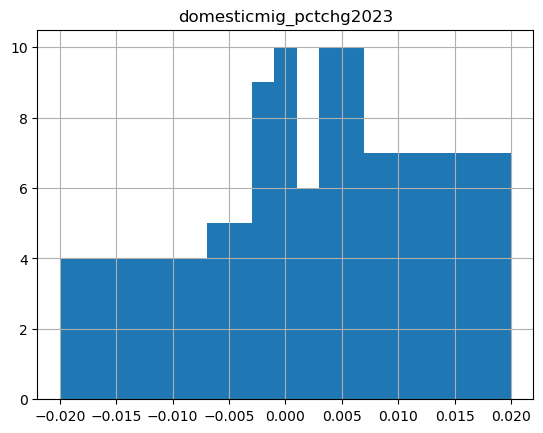

In [25]:
bin_cutoff_list = [-0.02, -0.007, -0.003, -0.001, 0.001, 0.003, 0.007, 0.02]
net_domesticmigr_df.hist(column="domesticmig_pctchg2023", bins=bin_cutoff_list)

In [26]:
# Add cat_label, fill_color, and label_color columns to net_domesticmigr_df
fig3_fill_color_list = [
    "#de2d26", "#fc9272", "#fee0d2", "white", "#deebf7", "#9ecae1", "#3182bd"
]
fig3_label_color_list = [
    "white", "black", "black", "black", "black", "black", "white"
]
net_domesticmigr_plot_df = net_domesticmigr_df.copy()
net_domesticmigr_plot_df["cat_label"] = ""
net_domesticmigr_plot_df["fill_color"] = ""
net_domesticmigr_plot_df["label_color"] = ""
for bin in range(len(bin_cutoff_list) - 1):
    bin_min = bin_cutoff_list[bin]
    bin_max = bin_cutoff_list[bin + 1]
    if bin == 0:
        net_domesticmigr_plot_df["cat_label"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] < bin_max)
        ] = f"Less than {(bin_max * 100):.1f}%"
        net_domesticmigr_plot_df["fill_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] < bin_max)
        ] = fig3_fill_color_list[bin]
        net_domesticmigr_plot_df["label_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] < bin_max)
        ] = fig3_label_color_list[bin]
    elif ((bin > 0) and (bin < len(bin_cutoff_list) - 2)):
        net_domesticmigr_plot_df["cat_label"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] >= bin_min) &
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] < bin_max)
        ] = f"{(bin_min * 100):.1f}% to {(bin_max * 100):.1f}%"
        net_domesticmigr_plot_df["fill_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] >= bin_min) &
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] < bin_max)
        ] = fig3_fill_color_list[bin]
        net_domesticmigr_plot_df["label_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] >= bin_min) &
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] < bin_max)
        ] = fig3_label_color_list[bin]
    elif bin == len(bin_cutoff_list) - 2:
        net_domesticmigr_plot_df["cat_label"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] >= bin_min)
        ] = f"Greater than {(bin_min * 100):.1f}%"
        net_domesticmigr_plot_df["fill_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] >= bin_min)
        ] = fig3_fill_color_list[bin]
        net_domesticmigr_plot_df["label_color"][
            (net_domesticmigr_plot_df["domesticmig_pctchg2023"] >= bin_min)
        ] = fig3_label_color_list[bin]

net_domesticmigr_plot_df

state_str state_abbrev  popestimate2022  domesticmig2023  \
0         South Carolina           SC          5282955            82562   
1               Delaware           DE          1019459            10320   
2         North Carolina           NC         10695965            97264   
3              Tennessee           TN          7048976            63417   
4                Florida           FL         22245521           194438   
5                Montana           MT          1122878             9485   
6                  Idaho           ID          1938996            15389   
7                  Maine           ME          1389338             9216   
8                  Texas           TX         30029848           186767   
9                Alabama           AL          5073903            30744   
10              Arkansas           AR          3046404            18106   
11              Oklahoma           OK          4019271            23587   
12               Georgia           GA         10913150            58206   
13          South Dakota           SD           909869             4812   
14               Arizona           AZ          7365684            36179   
15               Wyoming           WY           581629             2016   
16         New Hampshire           NH          1399003             4298   
17                Nevada           NV          3177421             8642   
18         West Virginia           WV          1774035             3595   
19              Kentucky           KY          4511563             8965   
20              Missouri           MO          6177168            11171   
21               Vermont           VT           647110              844   
22              Colorado           CO          5841039             7236   
23             Wisconsin           WI          5890543             5648   
24               Indiana           IN          6832274             4599   
25                  Utah           UT          3381236             1338   
26                  Ohio           OH         11759697              637   
27          North Dakota           ND           778912               -9   
28              Nebraska           NE          1968060             -834   
29            New Mexico           NM          2113476            -1088   
30              Virginia           VA          8679099            -6985   
31             Minnesota           MN          5714300            -4686   
32           Mississippi           MS          2938928            -2614   
33                  Iowa           IA          3199693            -3603   
34                Oregon           OR          4239379            -6051   
35              Michigan           MI         10033281           -15051   
36                Kansas           KS          2936716            -4574   
37          Pennsylvania           PA         12972091           -24825   
38            Washington           WA          7784477           -15276   
39  District of Columbia           DC           670949            -1509   
40           Connecticut           CT          3608706            -9016   
41          Rhode Island           RI          1093842            -3224   
42            New Jersey           NJ          9260817           -44666   
43              Maryland           MD          6163981           -30905   
44         Massachusetts           MA          6982740           -39149   
45             Louisiana           LA          4588023           -29692   
46              Illinois           IL         12582515           -83839   
47                Alaska           AK           733276            -5543   
48                Hawaii           HI          1439399           -11193   
49            California           CA         39040616          -338371   
50              New York           NY         19673200          -216778   

    domesticmig_pctchg2023  netdomesticmig_rank  uhaul2023_rank  \
0                 0.015628                    1

In [28]:
# fig3_title = (
#     "Figure 3. 2023 net domestic migration as percent of 2022 population"
# )
fig3_title = ""
output_file(
    "./images/fig3_net_domestic_migration_2023.html",
    title=fig3_title, mode='inline'
)
output_notebook()

# Download U.S. states shape files from US Census Bureau
# https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html
us_shapefile_path = (
    "https://github.com/OpenSourceEcon/AR-IndivBusTax/raw/main/data/" +
    "cb_2018_us_state_20m/cb_2018_us_state_20m.shp"
)
gdf = gpd.GeoDataFrame.from_file(us_shapefile_path)
gdf_json = gdf.to_json()
gjson = json.loads(gdf_json)

# Remove Puerto Rico from data
del(gjson["features"][7])

# Alaska
# Fix positive longitudes
min_lat_ak = 180  # initial value that will be adjusted
min_abs_lon_ak = 180  # initial value that will be adjusted
coords_list = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_ak = np.minimum(min_lat_ak, point[1])
        if point[0] > 0:
            gjson["features"][24]["geometry"][
                "coordinates"
            ][ind_isl][0][ind_pnt][0] = -180 - (180 - point[0])
        else:
            min_abs_lon_ak = np.minimum(min_abs_lon_ak, -point[0])

# Shrink the size of Alaska relative to its southestern most minimum lattitude
# and longitude
shrink_pct_ak = 0.65
coords_list_ak = gjson["features"][24]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_ak):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] - shrink_pct_ak * (point[0] +
                                                                min_abs_lon_ak)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - shrink_pct_ak * (point[1] -
                                                                min_lat_ak)

# Move Alaska closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-127, 44)
min_lat_ak_new = 44
min_abs_lon_ak_new = 127
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_ak -
                                                min_abs_lon_ak_new)
        gjson["features"][24]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_ak - min_lat_ak_new)

# Hawaii
list_ind_hi = 47
# Get minimum lattitude and minimum absolute longitude for Hawaii
min_lat_hi = 180  # initial value that will be adjusted
min_abs_lon_hi = 180  # initial value that will be adjusted
coords_list = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        min_lat_hi = np.minimum(min_lat_hi, point[1])
        min_abs_lon_hi = np.minimum(min_abs_lon_hi, -point[0])
# print("Minimum lattitude for Hawaii is", min_lat_hi)
# print("Minimum absolute longitude for Hawaii is", min_abs_lon_hi)

# Increase the size of Hawaii
incr_pct_hi = 0.4
coords_list_hi = gjson["features"][list_ind_hi]["geometry"]["coordinates"]
for ind_isl, island in enumerate(coords_list_hi):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + incr_pct_hi * (point[0] +
                                                              min_abs_lon_hi)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] + incr_pct_hi * (point[1] -
                                                              min_lat_hi)

# Move Hawaii closer to the mainland such that the minimum minimum absolute
# longitude and lattitude are (-125, 27)
min_lat_hi_new = 27.5
min_abs_lon_hi_new = 124.5
for ind_isl, island in enumerate(coords_list):
    for ind_pnt, point in enumerate(island[0]):
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][0] = point[0] + (min_abs_lon_hi -
                                                min_abs_lon_hi_new)
        gjson["features"][list_ind_hi]["geometry"][
            "coordinates"
        ][ind_isl][0][ind_pnt][1] = point[1] - (min_lat_hi - min_lat_hi_new)

# Add a state box around Delaware abbreviation DE
st_list_num = 2
de_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_de = [[
    [-75.4, 38.8],
    [-72.4, 38.3],
    [-72.4, 38.9],
    [-70.2, 38.9],
    [-70.2, 37.7],
    [-72.4, 37.7],
    [-72.4, 38.3]
]]
de_coord_list.append(new_box_de)
gjson["features"][st_list_num]["geometry"]["coordinates"] = de_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Washington, DC (District of Columbia) abbreviation DC
st_list_num = 35
dc_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_dc = [[
    [-77.0, 38.9],
    [-73.3, 35.5],
    [-73.3, 36.1],
    [-71.1, 36.1],
    [-71.1, 34.9],
    [-73.3, 34.9],
    [-73.3, 35.5]
]]
dc_coord_list.append(new_box_dc)
gjson["features"][st_list_num]["geometry"]["coordinates"] = dc_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Massachusetts abbreviation MD
st_list_num = 0
md_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_md = [[
    [-76.8, 39.3],
    [-72.7, 37.0],
    [-72.7, 37.6],
    [-70.5, 37.6],
    [-70.5, 36.4],
    [-72.7, 36.4],
    [-72.7, 37.0]
]]
md_coord_list.append(new_box_md)
gjson["features"][st_list_num]["geometry"]["coordinates"] = md_coord_list

# Add a state box around Massachusetts abbreviation MA
st_list_num = 29
ma_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ma = [[
    [-71.7, 42.2],
    [-68.5, 42.2],
    [-68.5, 42.8],
    [-66.3, 42.8],
    [-66.3, 41.6],
    [-68.5, 41.6],
    [-68.5, 42.2]
]]
ma_coord_list.append(new_box_ma)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ma_coord_list

# Add a state box around New Jersey abbreviation NJ
st_list_num = 34
nj_coord_list = [gjson["features"][st_list_num]["geometry"]["coordinates"]]
new_box_nj = [[
    [-74.4, 40.1],
    [-72.0, 39.7],
    [-72.0, 40.3],
    [-69.8, 40.3],
    [-69.8, 39.1],
    [-72.0, 39.1],
    [-72.0, 39.7]
]]
nj_coord_list.append(new_box_nj)
gjson["features"][st_list_num]["geometry"]["coordinates"] = nj_coord_list
gjson["features"][st_list_num]["geometry"]["type"] = "MultiPolygon"

# Add a state box around Rhode Island abbreviation RI
st_list_num = 50
ri_coord_list = gjson["features"][st_list_num]["geometry"]["coordinates"]
new_box_ri = [[
    [-71.5, 41.7],
    [-69.5, 40.4],
    [-69.5, 41.0],
    [-67.3, 41.0],
    [-67.3, 39.8],
    [-69.5, 39.8],
    [-69.5, 40.4]
]]
ri_coord_list.append(new_box_ri)
gjson["features"][st_list_num]["geometry"]["coordinates"] = ri_coord_list

# Merge the state domestic migration percent change data into gjson for each
# state
net_domesticmigr_plot_df
for ind_st, state in enumerate(gjson["features"]):
    st_abbrev = state["properties"]["STUSPS"]
    state["properties"]["netmigr_pct_cat"] = net_domesticmigr_plot_df[
        net_domesticmigr_plot_df["state_abbrev"]==st_abbrev
    ]["cat_label"].iloc[0]
    state["properties"]["net_migr_pct_chg"] = net_domesticmigr_plot_df[
        net_domesticmigr_plot_df["state_abbrev"]==st_abbrev
    ]["domesticmig_pctchg2023"].iloc[0]

fig3_cat_labels = [
    "Less than -0.7%", "-0.7% to -0.3%", "-0.3% to -0.1%", "-0.1% to 0.1%",
    "0.1% to 0.3%", "0.3% to 0.7%", "Greater than 0.7%"
]
# fig3_fill_color_list = [
#     "#de2d26", "#fc9272", "#fee0d2", "white", "#deebf7", "#9ecae1", "#3182bd"
# ]

source_shapes = {}
for category in fig3_cat_labels:
    source_shapes[category] = {"type": "FeatureCollection", "features": []}

for item in gjson["features"]:
    source_shapes[
        item["properties"]["netmigr_pct_cat"]
    ]['features'].append(item)

TOOLS = "pan, box_zoom, wheel_zoom, hover, save, reset, help"

fig3 = figure(
    title=fig3_title,
    height=500,
    width=950,
    tools=TOOLS,
    min_border = 0,
    x_axis_location = None, y_axis_location = None,
    toolbar_location="right"
)
fig3.toolbar.logo = None
fig3.grid.grid_line_color = None

cmap = CategoricalColorMapper(
    palette=fig3_fill_color_list, factors=fig3_cat_labels
)
for category in fig3_cat_labels:
    source_shape_1 = GeoJSONDataSource(
        geojson = json.dumps(source_shapes[category])
    )
    fig3.patches(
        'xs', 'ys', source=source_shape_1, fill_alpha=0.7,
        fill_color = {'field': 'netmigr_pct_cat', 'transform': cmap},
        line_color ='black', line_width=1.0, line_alpha=0.3,
        hover_line_color="black", hover_line_width=3.0, legend_label=category)

    hover = fig3.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("State", "@NAME"),
        ("Pct chg category", "@netmigr_pct_cat"),
        ("2023 net domestic migration (%chg)", "@net_migr_pct_chg{0.00%}")
    ]

# Add 2-letter state abbreviation labels. See Bokeh documentation for labels at
# https://docs.bokeh.org/en/latest/docs/user_guide/basic/annotations.html.
label_lon_lat =[
    ["AL",  -87.40, 32.10],
    ["AK", -135.00, 48.30],
    ["AZ", -112.40, 34.00],
    ["AR",  -93.20, 34.30],
    ["CA", -121.00, 37.00],
    ["CO", -106.50, 38.50],
    ["CT",  -73.40, 41.25],
    ["DE",  -72.10, 37.80],
    ["DC",  -73.00, 35.00],
    ["FL",  -82.40, 28.00],
    ["GA",  -84.20, 32.20],
    ["HI", -126.00, 28.00],
    ["ID", -115.00, 43.00],
    ["IL",  -89.60, 39.50],
    ["IN",  -86.90, 39.60],
    ["IA",  -94.40, 41.60],
    ["KS",  -99.50, 38.00],
    ["KY",  -86.00, 37.00],
    ["LA",  -93.00, 30.20],
    ["ME",  -70.00, 44.50],
    ["MD",  -72.40, 36.50],
    ["MA",  -68.20, 41.80],
    ["MI",  -85.40, 42.70],
    ["MN",  -95.30, 45.50],
    ["MS",  -90.60, 32.10],
    ["MO",  -93.50, 38.00],
    ["MT", -110.50, 46.50],
    ["NE", -100.50, 41.00],
    ["NV", -118.00, 39.00],
    ["NH",  -72.45, 42.70],
    ["NM", -107.00, 34.00],
    ["NJ",  -71.60, 39.30],
    ["NY",  -76.00, 42.50],
    ["NC",  -79.20, 35.00],
    ["ND", -101.50, 46.80],
    ["OH",  -83.80, 39.90],
    ["OK",  -98.00, 35.00],
    ["OR", -121.50, 43.50],
    ["PA",  -78.50, 40.40],
    ["RI",  -69.00, 40.00],
    ["SC",  -81.50, 33.30],
    ["SD", -101.00, 44.00],
    ["TN",  -87.10, 35.40],
    ["TX", -100.00, 31.00],
    ["UT", -112.50, 39.00],
    ["VT",  -73.20, 44.10],
    ["VA",  -79.00, 37.10],
    ["WA", -121.00, 47.00],
    ["WV",  -81.90, 38.00],
    ["WI",  -90.40, 44.00],
    ["WY", -108.50, 42.50]
]
# Add text color element to each state in list based on tax type
for i, state in enumerate(label_lon_lat):
    label_lon_lat[i].append(
        net_domesticmigr_plot_df[
            net_domesticmigr_plot_df["state_abbrev"]==state[0]
        ]["label_color"].iloc[0]
    )
label_abbrev = [state[0] for state in label_lon_lat]
label_lon = [state[1] for state in label_lon_lat]
label_lat = [state[2] for state in label_lon_lat]
label_color = [state[3] for state in label_lon_lat]
state_cds = ColumnDataSource(data=dict(
    lon=label_lon,
    lat=label_lat,
    abbrev=label_abbrev,
    txtcolor=label_color
))

state_labels = LabelSet(
    x='lon', y='lat', text='abbrev', text_font_size="8pt",
    text_color='txtcolor', text_font_style="bold", x_offset=0, y_offset=0,
    source=state_cds
)

fig3.add_layout(state_labels)

# Legend properties
fig3.legend.click_policy = 'mute'
fig3.legend.location = "center_left"

note_text_list3 = [
    (
        '  Source: Richard W. Evans (@RickEcon), updated Nov. 14, 2024. Data ' +
        'are from US Census Bureau, U-Haul, United Van Lines. See also Tax'
    ),
    (
        '      Foundation, Loughead (2024a).'
    )
]
for note_text in note_text_list3:
    caption = Title(
        text=note_text, align='left', text_font_size='11pt',
        text_font_style='italic',
        text_color='#434244',
        # text_font='Open Sans'
    )
    fig3.add_layout(caption, 'below')

show(fig3)

Loading BokehJS ...

## 3. Create Figures 4 and 5

### 3.1. Figure 4. Rainy Day Fund and Total Reserves as Percentages of General-Fund Expenditures, South Carolina and 50-State Median: 2000-2024

Get the Pew state rainy day fund data. This does not include District of Columbia. The 2022 data is now final. The 2023 data is labeled as "Enacted" which means projected based on enacted legislation.

In [29]:
# Read in the Pew data on rainy day funds by year and state from worksheet
rain_totbal_path = (
    "https://github.com/OpenSourceEcon/AR-IndivBusTax/blob/main/data/" +
    "Pew_ReservesData.csv?raw=true"
)

In [30]:
# Create a DataFrame of just the rainy day funds in $ by state and by year
rain_dol_df = pd.read_csv(
    rain_totbal_path,
    skiprows=5,
    skipfooter=4,
    index_col=0,
    usecols=[
        0, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125
    ],
    names=[
        'state', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
        '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
        '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'
    ]
)
rain_dol_df

2000         2001         2002        2003  \
state                                                                
Alabama              2500000      7500000    261000000    68000000   
Alaska            2734200000   2994800000   2114000000  2092500000   
Arizona            407800000    391500000     65000000    13800000   
Arkansas                   0            0            0           0   
California        8665500000   1563800000            0           0   
Colorado           583400000            0            0           0   
Connecticut        564000000    594700000            0           0   
Delaware           114000000    126000000    128000000   129000000   
Florida           1666100000    894000000    941000000   958900000   
Georgia            551300000    734400000    700000000   184700000   
Hawaii               5800000     21200000     50000000           0   
Idaho               36000000     53200000     53000000           0   
Illinois                   0    225000000    226000000   225700000   
Indiana            539900000    525900000    269000000   278500000   
Iowa               443800000    405200000    166000000           0   
Kansas                     0            0            0           0   
Kentucky           278600000    239800000            0     5100000   
Louisiana           59000000    196700000    266000000           0   
Maine              143700000    143700000     20000000           0   
Maryland           582000000    888000000    548000000   490200000   
Massachusetts     1608365000   2294200000    882000000   641300000   
Michigan          1264400000    994200000    145000000           0   
Minnesota         1379700000   1574200000            0   103700000   
Mississippi        231900000    189500000    111000000    22600000   
Missouri           293400000    452000000    469900000   462400000   
Montana                    0            0            0           0   
Nebraska           142200000    170200000    110000000    59100000   
Nevada             136341000    136300000    136000000     1300000   
New Hampshire       20000000     55200000            0    17300000   
New Jersey         698200000    720000000            0           0   
New Mexico                 0            0            0           0   
New York           547000000    627000000    710000000   710000000   
North Carolina      37500000    157500000            0   150000000   
North Dakota               0     40000000     25000000     6000000   
Ohio              1002500000   1010600000    428000000   180700000   
Oklahoma           157600000    340100000     72000000      100000   
Oregon                     0            0            0           0   
Pennsylvania      1097400000   1126700000            0    70000000   
Rhode Island        71300000     79700000     82000000    83600000   
South Carolina     145400000     60500000            0           0   
South Dakota        36600000    110600000    116000000   106500000   
Tennessee          165100000    178000000    178000000   178000000   
Texas               84700000    196500000    904000000   560500000   
Utah               109700000    120300000     20000000    26600000   
Vermont             41400000     43000000     13000000    23600000   
Virginia           574600000    715600000    472400000   247500000   
Washington         753955000    462100000    116000000           0   
West Virginia       73200000     79100000     56000000    57800000   
Wisconsin                  0            0            0           0   
Wyoming             38700000     64800000     65000000   247000000   
50-state median  28088761000  22003300000  10918300000  8402000000   

                        2004         2005         2006         2007  \
state                                                                 
Alabama            104000000    157000000    418700000    676600000   
Alaska            2155100000   2274200000   2267100000   3015200000   
Arizona             13500000 

In [31]:
# Create a DataFrame of just the rainy day funds balances as a percent of
# general fund expenditures by state and by year
rain_pct_df = pd.read_csv(
    rain_totbal_path,
    skiprows=5,
    skipfooter=4,
    index_col=0,
    usecols=[
        0, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150
    ],
    names=[
        'state', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
        '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
        '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'
    ]
)
# rain_pct_df

In [32]:
# Create a DataFrame of just the total balances and reserves in $ by state and
# by year
totbal_dol_df = pd.read_csv(
    rain_totbal_path,
    skiprows=5,
    skipfooter=4,
    index_col=0,
    usecols=[
        0, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 48, 49, 50
    ],
    names=[
        'state', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
        '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
        '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'
    ]
)
# totbal_dol_df

In [33]:
# Create a DataFrame of just the total balances and reserves as a percent of
# general fund expenditures by state and by year
totbal_pct_df = pd.read_csv(
    rain_totbal_path,
    skiprows=5,
    skipfooter=4,
    index_col=0,
    usecols=[
        0, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75
    ],
    names=[
        'state', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
        '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
        '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'
    ]
)
# totbal_pct_df

In [34]:
rain_pct_50_df = rain_pct_df.loc["50-state median", :].to_frame().reset_index()
rain_pct_50_df.rename(
    columns = {"index":"year", "50-state median":"fraction"}, inplace = True
)
rain_pct_50_df["percent"] = 100 * rain_pct_50_df["fraction"]
rain_pct_50_df["series"] = "50-state median Rainy Day Fund"

rain_pct_ar_df = rain_pct_df.loc["Arkansas", :].to_frame().reset_index()
rain_pct_ar_df = rain_pct_ar_df.rename(
    columns = {"index":"year", "Arkansas":"fraction"}
)
rain_pct_ar_df["percent"] = 100 * rain_pct_ar_df["fraction"]
rain_pct_ar_df["series"] = "Arkansas Rainy Day Fund"

totbal_pct_50_df = \
    totbal_pct_df.loc["50-state median", :].to_frame().reset_index()
totbal_pct_50_df = totbal_pct_50_df.rename(
    columns = {"index":"year", "50-state median":"fraction"}
)
totbal_pct_50_df["percent"] = 100 * totbal_pct_50_df["fraction"]
totbal_pct_50_df["series"] = "50-state median total reserve balances"

totbal_pct_ar_df = totbal_pct_df.loc[
    "Arkansas", :
].to_frame().reset_index()
totbal_pct_ar_df = totbal_pct_ar_df.rename(
    columns = {'index':'year', "Arkansas":"fraction"}
)
totbal_pct_ar_df["percent"] = 100 * totbal_pct_ar_df["fraction"]
totbal_pct_ar_df["series"] = "Arkansas total reserve balances"

# Merge the four DataFrames to save the joint dataframe as a .csv
fig4_source_df = rain_pct_50_df[['year', 'percent']].rename(
    columns={'percent':'rain_50m_pct'}
)
fig4_source_df = pd.merge(
    fig4_source_df,
    rain_pct_ar_df[['year', 'percent']].rename(
        columns={'percent':'rain_ar_pct'}
    ),
    on='year', how='inner'
)
fig4_source_df = pd.merge(
    fig4_source_df,
    totbal_pct_50_df[['year', 'percent']].rename(
        columns={'percent':'totbal_50m_pct'}
    ),
    on='year', how='inner'
)
fig4_source_df = pd.merge(
    fig4_source_df,
    totbal_pct_ar_df[['year', 'percent']].rename(
        columns={'percent':'totbal_ar_pct'}
    ),
    on='year', how='inner'
)
fig4_source_df.to_csv('./data/fig4_source.csv', index=False)

fig4_source_df

year  rain_50m_pct  rain_ar_pct  totbal_50m_pct  totbal_ar_pct
0   2000      4.127259     0.000000        8.766520       0.000000
1   2001      4.614270     0.000000        7.148315       0.000000
2   2002      1.655668     0.000000        2.887308       0.000000
3   2003      0.722015     0.000000        2.656212       0.000000
4   2004      1.844196     0.000000        5.246650       0.000000
5   2005      2.459819     0.000000        9.016673       0.000000
6   2006      4.553273     0.000000       11.801597       0.000000
7   2007      4.738918     0.000000       11.327766       0.000000
8   2008      4.834502     0.000000        8.292193       0.000000
9   2009      2.728263     0.000000        4.582794       0.000000
10  2010      1.638317     0.000000        4.488299       0.000000
11  2011      1.761059     0.000000        6.368404       0.000000
12  2012      2.486130     0.000000        7.907533       0.000000
13  2013      3.558071     0.000000        9.956752       0.000000
14  2014      4.524613     0.000000        7.292836       0.000000
15  2015      4.918311     0.000000        9.204278       0.000000
16  2016      5.339671     0.000000        9.739579       3.417848
17  2017      5.613689     2.307059        8.315685       2.307059
18  2018      6.547734     2.303955       11.724584       2.303955
19  2019      7.929661     2.710629       13.993790       7.961251
20  2020      8.439704     3.217018       12.711729       3.272669
21  2021     10.288485     3.559563       27.123898      19.589464
22  2022     11.484141    20.720782       39.507860      48.044177
23  2023     12.290710    25.398406       34.875047      44.671315
24  2024     13.180889    40.551435       24.070922      44.437278

In [37]:
# Create Bokeh plot Fig 4: Arkansas Rainy Day fund and total reserves as
# a percentage of general fund expenditures: 2000-2024
fig4_title_lst = [
    ("Figure 4. Arkansas Rainy Day fund and total reserves as a"),
    ("percentage of general fund expenditures: 2000-2024"),
]
# fig4_title_lst = []
fig4_title_short = "Figure 4. AR Rainy Day fund and total reserves"
filename_fig4 = "fig4_ar_raintotbal_tseries.html"
output_file(
    os.path.join(image_dir, filename_fig4),
    title=fig4_title_short,
    mode="inline",
)
output_notebook()

# Format the tooltip
tooltips_fig4 = [
    ("Series:", "@series"),
    ("Year:", "@year"),
    ("Pct. of Gen. Fund Exps.:", "@fraction{0.0%}")
]

min_year = 2000
max_year = 2024
min_pct = 2.0
max_pct = 0.0
pct_buffer = 0.05
fig4_height = 500
fig4_width = 800

var_list = [rain_pct_ar_df, rain_pct_50_df, totbal_pct_ar_df, totbal_pct_50_df]
color_list = ["#3477A5", "#D5AB53", "#3477A5", "#D5AB53"]
marker_list = ["circle", "circle", "square", "square"]
legend_label_list = [
    "Rainy day fund, Arkansas",
    "Rainy day fund, 50-state median",
    "Total balances, Arkansas",
    "Total balances, 50-state median"
]
cds_list = []

for k, df in enumerate(var_list):
    min_pct = np.minimum(min_pct, df["percent"].min())
    max_pct = np.maximum(max_pct, df["percent"].max())
    cds_list.append(ColumnDataSource(df))

fig4 = figure(
    height=fig4_height,
    width=fig4_width,
    x_axis_label='Year',
    x_range=(min_year - 1, max_year + 1.6),
    y_axis_label='Percent of general fund expenditures',
    y_range=(min_pct - pct_buffer * (max_pct - min_pct),
             max_pct + pct_buffer * (max_pct - min_pct)),
    tools=["save", "help"],
    toolbar_location="right"
)
fig4.toolbar.logo = None

# Turn off any pan, drag, or scrolling ability
fig4.toolbar.active_drag = None
fig4.toolbar.active_scroll = None
fig4.toolbar.active_tap = None

# Set title font size and axes font sizes
fig4.xaxis.axis_label_text_font_size = '12pt'
fig4.xaxis.major_label_text_font_size = '12pt'
fig4.xaxis.major_label_text_color = '#434244'
fig4.yaxis.axis_label_text_font_size = '12pt'
fig4.yaxis.major_label_text_font_size = '12pt'
fig4.yaxis.major_label_text_color = '#434244'

# Modify tick intervals for X-axis and Y-axis
fig4.xaxis.ticker = SingleIntervalTicker(interval=2, num_minor_ticks=2)
fig4.xaxis.axis_line_color = '#434244'
fig4.xaxis.major_tick_line_color = '#434244'
fig4.xaxis.minor_tick_line_color = '#434244'
fig4.xgrid.ticker = SingleIntervalTicker(interval=2)
fig4.yaxis.ticker = SingleIntervalTicker(interval=10, num_minor_ticks=5)
fig4.yaxis.axis_line_color = '#434244'
fig4.yaxis.major_tick_line_color = '#434244'
fig4.yaxis.minor_tick_line_color = '#434244'
fig4.ygrid.ticker = SingleIntervalTicker(interval=10)

# Create lines and markers for time series
for k, yvar in enumerate(var_list):
    fig4.line(x='year', y='percent', source=cds_list[k], color=color_list[k],
              line_width=4, alpha=0.7)
    fig4.scatter(x='year', y='percent', source=cds_list[k], size=10,
                 line_width=1, line_color='black', fill_color=color_list[k],
                 marker=marker_list[k], line_alpha=0.7, fill_alpha=0.7,
                 legend_label=legend_label_list[k])

fig4.segment(x0=2023.4, y0=min_pct - pct_buffer * (max_pct - min_pct),
             x1=2023.4, y1=max_pct + pct_buffer * (max_pct - min_pct),
             color='#434244', line_dash='6 2', line_width=2)

label_projected = Label(
    x=2023.5, y=17.0, x_units='data', y_units='data', text='Projected',
    text_font_size='9pt', text_color='#434244'
)
fig4.add_layout(label_projected)

# Add legend
fig4.legend.location = 'top_center'
fig4.legend.border_line_width = 1
fig4.legend.border_line_color = '#434244'
fig4.legend.border_line_alpha = 1
fig4.legend.label_text_font_size = '12pt'
fig4.legend.label_text_color = '#434244'

# Add title and subtitle to the plot doing reverse loop through items in
# fig_title_lst
for title_line_str in fig4_title_lst[::-1]:
    fig4.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="15pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list4 = [
    (
        'Source: Pew Charitable Trusts, "Fiscal 50: State Trends and '+
        'Analysis," Sep. 19, 2024, accessed Sep. 24, 2024.'
    )
]
for note_text in note_text_list4:
    caption = Title(
        text=note_text, align='left', text_font_size='11pt',
        text_font_style='italic',
        text_color='#434244',
        # text_font='Open Sans'
    )
    fig4.add_layout(caption, 'below')

# Add the HoverTool to the figure
fig4.add_tools(
    HoverTool(
        tooltips=tooltips_fig4,
        visible=False
    )
)

show(fig4)

Loading BokehJS ...

### 3.2. Figure 5. Estimated 2024 Rainy Day Fund Balances and Total Reserves and Balances as Percentages of General-Fund Expenditures

In [38]:
rain_pct_2024_df = rain_pct_df.loc[:'Wyoming', '2024'].to_frame().reset_index()
rain_pct_2024_df = rain_pct_2024_df.rename(
    columns = {"index": "state", "2024": "rain_frac"}
)
rain_pct_2024_df["rain_pct"] = 100 * rain_pct_2024_df["rain_frac"]
rain_pct_2024_df = rain_pct_2024_df.drop('rain_frac', axis=1)

rain_dol_2024_df = rain_dol_df.loc[:'Wyoming', '2024'].to_frame().reset_index()
rain_dol_2024_df = rain_dol_2024_df.rename(
    columns = {"index": "state", "2024": "rain_dol"}
)

totbal_pct_2024_df = \
    totbal_pct_df.loc[:'Wyoming', '2024'].to_frame().reset_index()
totbal_pct_2024_df = totbal_pct_2024_df.rename(
    columns = {"index": "state", "2024": "totbal_frac"}
)
totbal_pct_2024_df["totbal_pct"] = 100 * totbal_pct_2024_df["totbal_frac"]
totbal_pct_2024_df = totbal_pct_2024_df.drop('totbal_frac', axis=1)

totbal_dol_2024_df = \
    totbal_dol_df.loc[:'Wyoming', '2024'].to_frame().reset_index()
totbal_dol_2024_df = totbal_dol_2024_df.rename(
    columns = {"index": "state", "2024": "totbal_dol"}
)

# Merge the four DataFrames
rain_totbal_pct_dol_2024_df = rain_pct_2024_df.copy()
rain_totbal_pct_dol_2024_df = pd.merge(
    rain_totbal_pct_dol_2024_df, rain_dol_2024_df, on='state', how='inner'
)
rain_totbal_pct_dol_2024_df["rain_color"] = "#D5AB53"
rain_totbal_pct_dol_2024_df["rain_color"][
    rain_totbal_pct_dol_2024_df["state"]=="Arkansas"
] = "#EED17E"
rain_totbal_pct_dol_2024_df = pd.merge(
    rain_totbal_pct_dol_2024_df, totbal_pct_2024_df, on='state', how='inner'
)
rain_totbal_pct_dol_2024_df = pd.merge(
    rain_totbal_pct_dol_2024_df, totbal_dol_2024_df, on='state', how='inner'
)
rain_totbal_pct_dol_2024_df["totbal_color"] = "#3477A5"
rain_totbal_pct_dol_2024_df["totbal_color"][
    rain_totbal_pct_dol_2024_df["state"]=="Arkansas"
] = "#74AAC7"

# Create a new variable that is totbal_pct - rain_pct
rain_totbal_pct_dol_2024_df["totbal_rain_pct_dif"] = (
    rain_totbal_pct_dol_2024_df["totbal_pct"] -
    rain_totbal_pct_dol_2024_df["rain_pct"]
)

# Sort by total reserves balances percent
rain_totbal_pct_dol_2024_sorted_df = rain_totbal_pct_dol_2024_df.sort_values(
    by=['totbal_pct', 'rain_pct', 'state'], ascending=[True, True, True]
)

rain_totbal_pct_dol_2024_sorted_df.to_csv(
    os.path.join(data_dir, "fig5_source.csv"), index=False
)
rain_totbal_pct_dol_2024_sorted_df

state   rain_pct     rain_dol rain_color  totbal_pct  \
12        Illinois   4.070363   2145000000    #D5AB53    7.685301   
41       Tennessee   7.607244   2050000000    #D5AB53    8.301173   
23     Mississippi   9.505247    634000000    #D5AB53    9.505247   
38    Rhode Island   6.227923    335000000    #D5AB53    9.871723   
40    South Dakota  10.156581    240000000    #D5AB53   10.156581   
13         Indiana   8.197753   1824000000    #D5AB53   10.341573   
17       Louisiana   7.895376    975000000    #D5AB53   10.980646   
19        Maryland   9.119953   2512000000    #D5AB53   11.073192   
2          Arizona   8.772538   1518000000    #D5AB53   12.124364   
5         Colorado  12.604804   2225000000    #D5AB53   13.550872   
45        Virginia  14.606492   4599000000    #D5AB53   14.628724   
44         Vermont  12.155389    291000000    #D5AB53   14.661654   
29      New Jersey   0.558058    306000000    #D5AB53   14.879726   
4       California  11.789111  27222000000    #D5AB53   16.366258   
6      Connecticut  16.539737   3692000000    #D5AB53   16.539737   
43            Utah   8.612683   1187000000    #D5AB53   16.550573   
46      Washington   5.457323   1768500000    #D5AB53   17.840832   
28   New Hampshire  15.795148    293000000    #D5AB53   18.059299   
34            Ohio  10.749630   3780000000    #D5AB53   18.112274   
21        Michigan  12.658308   1989000000    #D5AB53   19.697066   
8          Florida   6.918102   4140000000    #D5AB53   20.872951   
32  North Carolina  15.946554   4750000000    #D5AB53   21.197167   
22       Minnesota   8.595437   3263000000    #D5AB53   22.403983   
42           Texas  18.029664  19972000000    #D5AB53   22.803391   
10          Hawaii  13.703469   1513000000    #D5AB53   23.448963   
48       Wisconsin   7.925675   1800000000    #D5AB53   24.692880   
18           Maine  19.107777    968000000    #D5AB53   25.266482   
20   Massachusetts  18.510634   8956000000    #D5AB53   27.253374   
27          Nevada  22.049078   1231000000    #D5AB53   27.888232   
11           Idaho  22.837573   1167000000    #D5AB53   28.982388   
37    Pennsylvania  14.351042   6402000000    #D5AB53   30.199507   
24        Missouri   5.843335    925000000    #D5AB53   30.884397   
14            Iowa  11.299037    962000000    #D5AB53   32.428941   
36          Oregon  14.447891   2329000000    #D5AB53   32.971464   
47   West Virginia  18.763294   1235000000    #D5AB53   33.287754   
26        Nebraska  17.207308    923000000    #D5AB53   34.097688   
25         Montana  14.426992    496000000    #D5AB53   35.456661   
30      New Mexico  36.299047   4496000000    #D5AB53   36.299047   
35        Oklahoma  19.377328   2029000000    #D5AB53   38.993410   
16        Kentucky  26.112634   3714000000    #D5AB53   39.365816   
0          Alabama  21.454313   2679000000    #D5AB53   42.003684   
39  South Carolina   8.809271   1163000000    #D5AB53   42.826844   
9          Georgia  14.877766   5392000000    #D5AB53   44.404282   
31        New York   6.179437   6256000000    #D5AB53   44.417665   
3         Arkansas  40.551435   2515000000    #EED17E   44.437278   
7         Delaware   5.175397    329000000    #D5AB53   44.989775   
15          Kansas  17.025144   1686000000    #D5AB53   45.279208   
1           Alaska  48.299962   2557000000    #D5AB53   48.299962   
49         Wyoming  69.839572   1306000000    #D5AB53   69.839572   
33    North Dakota  29.986877    914000000    #D5AB53   75.131234   

     totbal_dol totbal_color  totbal_rain_pct_dif  
12   4050000000      #3477A5             3.614938  
41   2237000000      #3477A5             0.693929  
23    634000000      #3477A5             0.000000  
38    531000000      #3477A5             3.643800  
40    240000000      #3477A5             0.000000  
13   2301000000      #3477A5             2.143820  
17   1356000000      #3477A5             3.085270  
19   3050000000      #3477A5             1.953239  
2    2098000000      #347

In [41]:
# Create Bokeh plot Fig 5: State 2024 Rainy day Fund Balances and Total Fund
# Balances as Percent of General Fund Expenditures
fig5_title_lst = [
    ("Figure 5. State 2024 Rainy day Fund Balances and Total"),
    ("Fund Balances as Percent of General Fund Expenditures")
]
# fig5_title_lst = []
fig5_title_short = "Figure 5. State 2024 Rainy Day fund and Total Reserves"
filename_fig5 = "fig5_rain_totbal_pct_2024.html"
output_file(
    os.path.join(image_dir, filename_fig5),
    title=fig5_title_short,
    mode="inline",
)
output_notebook()

states = rain_totbal_pct_dol_2024_sorted_df['state'].tolist()
legend_label_list_fig5 = ["Rainy day fund", "Total reserves and balances"]
rain_totbal_pct_dol_2024_cds = \
    ColumnDataSource(rain_totbal_pct_dol_2024_sorted_df)

min_pct = rain_totbal_pct_dol_2024_sorted_df['rain_pct'].min()
max_pct = rain_totbal_pct_dol_2024_sorted_df['totbal_pct'].max()
pct_buffer = 0.05
fig5_height = 900
fig5_width = 550

fig5 = figure(
    height=fig5_height,
    width=fig5_width,
    y_range=states,
    x_axis_label='Percentage of general fund expenditures',
    x_range=(min_pct - pct_buffer * (max_pct - min_pct),
             max_pct + pct_buffer * (max_pct - min_pct)),
    tools=["save", "help"],
    toolbar_location="right"
)
fig5.toolbar.logo = None

# Turn off any pan, drag, or scrolling ability
fig5.toolbar.active_drag = None
fig5.toolbar.active_scroll = None
fig5.toolbar.active_tap = None

# Set title font size and axes font sizes
fig5.xaxis.axis_label_text_font_size = '11pt'
fig5.xaxis.major_label_text_font_size = '11pt'
fig5.xaxis.major_label_text_color = '#434244'
fig5.yaxis.axis_label_text_font_size = '9pt'
fig5.yaxis.major_label_text_font_size = '9pt'
fig5.yaxis.major_label_text_color = '#434244'

# Modify tick intervals for X-axis and Y-axis
fig5.xaxis.ticker = SingleIntervalTicker(interval=10, num_minor_ticks=5)
fig5.xaxis.axis_line_color = '#434244'
fig5.xaxis.major_tick_line_color = '#434244'
fig5.xaxis.minor_tick_line_color = '#434244'
fig5.xgrid.ticker = SingleIntervalTicker(interval=10)
fig5.yaxis.axis_line_color = '#434244'
fig5.yaxis.major_tick_line_color = '#434244'
fig5.yaxis.minor_tick_line_color = '#434244'

fig5.hbar_stack(
    ['rain_pct', 'totbal_rain_pct_dif'], y='state', height=0.9,
    color=['rain_color', 'totbal_color'],
    source=rain_totbal_pct_dol_2024_cds, legend_label=legend_label_list_fig5
)

# Add information on hover
tooltips_fig5 = [
    ('State', '@state'),
    ('Rainy day fund % exps.','@rain_pct{0.0}' + '%'),
    ('Total balances % exps.','@totbal_pct{0.0}' + '%'),
]
fig5.add_tools(HoverTool(tooltips=tooltips_fig5, visible=False))

# Add legend
fig5.legend.location = (190, 240)
fig5.legend.border_line_width = 1
fig5.legend.border_line_color = '#434244'
fig5.legend.border_line_alpha = 1
fig5.legend.label_text_color = '#434244'
fig5.legend.label_text_font_size = '11pt'
fig5.legend.label_text_color = '#434244'
fig5.y_range.range_padding = 0.02

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig5_title_lst[::-1]:
    fig5.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list5 = [
    (
        'Source: Pew Charitable Trusts, "Fiscal 50: State Trends and '+
        'Analysis,"'
    ),
    ('        Sep. 19, 2024, accessed Sep. 24, 2024.'),
    (
        'Note: For states in which the blue bar is not visible for total ' +
        'balances'
    ),
    (
        '        and reserves, the value equals the rainy day fund balance'
    ),
    (
        '        percentage.'
    )
]
for note_text in note_text_list5:
    caption = Title(
        text=note_text, align='left', text_font_size='10pt',
        text_font_style='italic', text_color='#434244'
    )
    fig5.add_layout(caption, 'below')

show(fig5)

Loading BokehJS ...

## 4. Moving to a flat individual income tax
The Louisiana individual income tax currently is almost flat. The top rate as of Jan. 1, 2023 is 4.25% on net income (LA adjusted AGI) above $100,000 for joint and widow filers and above $50,000 for single, separate, and head of household filers. Show the revenue cost and distributional changes for moving to a flat tax with an increased standard deduction to make sure filer’s tax liability increases using FiscalSim-US.


**Louisiana 2024 individual income tax rates and brackets as of January 1, 2024**
|                   | Single | Married filing jointly | Dependent |
| --- | --- | --- | --- |
| MTR rate 1 | 1.85% | 1.85% | |
| income bracket lower bound 1 | $0 | $0 | |
| MTR rate 2 | 3.50% | 3.50% | |
| income bracket lower bound 2 | $12,500 | $25,000 | |
| MTR rate 3 | 4.25% | 4.25% | |
| income bracket lower bound 3 | $50,000 | $100,000 | |
| Personal exemption | $4,500 | $9,000 | $1,000 |

### 4.1. Figure 6. Louisiana current progressive marginal tax rates on employment income versus proposed 3.0% flat tax rate

In [71]:
# Create Bokeh plot of Figure 6 current vs proposed flat tax marginal rates
fig6_title_lst = (
    ("Figure 6. Louisiana 2024 progressive marginal tax rates"),
    ("on employment income versus proposed 3% flat tax")
)
# fig6_title_lst = ""
fig6_title_short = "Figure 6. LA 2024 progressive vs flat tax rate"
filename_fig6 = "fig6_CurrReformTaxRates.html"
output_file(
    os.path.join(image_dir, filename_fig6),
    title=fig6_title_short,
    mode="inline",
)
output_notebook()

# Create data objects for plot
flat_tax_rate1 = 0.03
curr_tax_rates = [0.0185, 0.0350, 0.0425]
min_marg_tax_rate_toplot = -0.003
max_marg_tax_rate_toplot = 0.0485

# Cheap trick to get the y-axis to only show from min_marg_tax_rate_toplot to
# max_margin_tax_rate_toplot
flat_tax_rate_adj = flat_tax_rate1 - min_marg_tax_rate_toplot
curr_tax_rates_adj = [x - min_marg_tax_rate_toplot for x in curr_tax_rates]
min_marg_tax_rate_toplot_adj = (min_marg_tax_rate_toplot -
                                min_marg_tax_rate_toplot)
max_marg_tax_rate_toplot_adj = (max_marg_tax_rate_toplot -
                                min_marg_tax_rate_toplot)

# Create label for under each bar on the x-axis
bar_under_labels = [
    "$0 to $25,000, married \n (or $0 to $12,500 for \n single filers)",
    "$25,000 to $100,000, married \n (or $12,500 to $50,000 for \n single filers)",
    "≥ $100,000, married \n (or ≥ $50,000 \n for single filers)"
]

fig6 = figure(
    height=550,
    width=800,
    x_axis_label="Tax bracket income ranges",
    y_axis_label="Statutory marginal tax rate",
    x_range=bar_under_labels,
    y_range=(min_marg_tax_rate_toplot, max_marg_tax_rate_toplot),
    tools=["save", "help"],
    toolbar_location="right"
)
fig6.title.text_font_size = "11pt"
fig6.toolbar.logo = None

vbar_curr = fig6.vbar(
    x=bar_under_labels, top=curr_tax_rates, color="steelblue", width=0.7,
    border_radius=8
)
fig6.xgrid.grid_line_color = None

# Dashed horizontal line at flat tax 0.050 or 5.0% with fill in shading below
flat_dash1 = fig6.line(
    x=[0, 3],
    y=[flat_tax_rate1, flat_tax_rate1],
    color="darkblue",
    line_width=3,
    line_dash="dashed",
    alpha=0.5,
)
fig6.vbar(
    x=1.5, top=flat_tax_rate1, color="powderblue", width=3.0, level='underlay'
)

# Add custom y-axis major tick labels
fig6.yaxis.major_label_overrides = {
    0.000: '0.0%', 0.005: '0.5%', 0.010: '1.0%', 0.015: '1.5%', 0.020: '2.0%',
    0.025: '2.5%', 0.030: '3.0%', 0.035: '3.5%', 0.040: '4.0%', 0.045: '4.5%'
}
fig6.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

# Add column height in percent at top center inside of each bar
label_bar1 = Label(
    x=0.42, y=0.014, text='1.85%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig6.add_layout(label_bar1)
label_bar2 = Label(
    x=1.42, y=0.036, text='3.50%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='darkblue'
)
fig6.add_layout(label_bar2)
label_bar3 = Label(
    x=2.42, y=0.038, text='4.25%', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig6.add_layout(label_bar3)
label_flat1 = Label(
    x=0.5, y=0.0302, text='3.00% flat tax rate', x_units='data',
    y_units='data', text_font_size='12pt', text_color='darkblue'
)
fig6.add_layout(label_flat1)

# Add legend
legend = Legend(
    items=[
        ("Current policy progressive tax rates", [vbar_curr]),
        ("Proposed 3% flat tax rate", [flat_dash1])
    ],
    location="center",
)
fig6.add_layout(legend, "above")
fig6.legend.orientation = "horizontal"
fig6.legend.spacing = 20

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig6_title_lst[::-1]:
    fig6.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list6 = [
    (
        'Note: The tax bracket income ranges under each bar are for married ' +
        'filing jointly, qualifying surviving spouse, and head of'
    ),
    (
        '         household filers. The income brackets in parentheses are ' +
        'for single and married filing separately filers.'
    )
]
for note_text in note_text_list6:
    caption = Title(
        text=note_text, align='left', text_font_size='10pt',
        text_font_style='italic', text_color='#434244'
    )
    fig6.add_layout(caption, 'below')


show(fig6)


Loading BokehJS ...

### 4.2. Figure 7. Current 2024 Louisiana personal exemption amounts by filer type plus proposed extra amount

In [63]:
# Create Bokeh plot of Figure 7 Current 2024 Louisiana personal exemption
# amounts by filer type plus proposed extra amount
# fig7_title_lst = (
#     (
#         "Figure 7. Current 2024 Louisiana personal exemption amounts by " +
#         "filer type"),
#     (
#         "plus proposed extra amount"
#     )
# )
fig7_title_lst = ""
fig7_title_short = (
    "Figure 7. Current 2024 LA personal exempt amounts"
)
filename_fig7 = "fig7_CurrReformLA_StdDeduct_3.html"
output_file(
    os.path.join(image_dir, filename_fig7),
    title=fig7_title_short,
    mode="inline",
)
output_notebook()

# Create standard deduction by filer type data for plot
filertypes7 = [
    "Married filing jointly", "Single", "Married filing separately",
    "Head of household", "Qualifying surviving spouse"
]
laws7a = [
    'Curr LA pers. exemption', 'Extra LA pers. exemption'
]
laws7b = [
    '2024 Curr. pers. exemption', 'Proposed extra LA pers. exemption'
]

data7 = {
    'filer_types': filertypes7,
    'Curr LA pers. exemption': [9_000, 4_500, 4_500, 9_000, 9_000],
    'Extra LA pers. exemption': [6_000, 3_500, 3_500, 1_000, 1_000]
}
palette7 = ["lightskyblue", "darkblue"]

# This creates [("Married", "Curr. pers. exemption"), ("Married", "Extra LA pers. exemption"),
# ("Single", "Curr. pers. exemption"), ("Single", "Extra LA pers. exemption"), ... ]
x7 = [ (filertype, law) for filertype in filertypes7 for law in laws7a]
# like an hstack for a tuple
pers_exempts7 = sum(
    zip(data7['Curr LA pers. exemption'], data7['Extra LA pers. exemption']), ()
)
pers_exempts7_strfmt = ['${:,.0f}'.format(x) for x in pers_exempts7]

source7 = ColumnDataSource(
    data=dict(
        x=x7, pers_exempts=pers_exempts7, pers_exempts_strfmt=pers_exempts7_strfmt
    )
)

fig7 = figure(
    x_range=filertypes7,
    y_range=(0, 17_000),
    height=550,
    width=850,
    x_axis_label="Filing status",
    y_axis_label="Personal Exemption",
    tools=["save", "help"],
    toolbar_location="right"
)
fig7.title.text_font_size = "11pt"
fig7.toolbar.logo = None

vbars7 = fig7.vbar_stack(
    laws7a, x='filer_types', width=0.85, source=data7, color=palette7,
    legend_label=laws7b, line_color="white", border_radius=5
)

label_bar1_cur = Label(
    x=0.30, y=8_000, text='$9,000', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7.add_layout(label_bar1_cur)

label_bar1_ref = Label(
    x=0.29, y=14_000, text='+$6,000', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7.add_layout(label_bar1_ref)

label_bar1_tot = Label(
    x=0.28, y=15_200, text='$15,000', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7.add_layout(label_bar1_tot)

label_bar2_cur = Label(
    x=1.30, y=3_500, text='$4,500', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7.add_layout(label_bar2_cur)

label_bar2_ref = Label(
    x=1.29, y=7_000, text='+$3,500', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7.add_layout(label_bar2_ref)

label_bar2_tot = Label(
    x=1.28, y=8_200, text='$8,000', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7.add_layout(label_bar2_tot)

label_bar3_cur = Label(
    x=2.30, y=3_500, text='$4,500', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7.add_layout(label_bar3_cur)

label_bar3_ref = Label(
    x=2.29, y=7_000, text='+$3,500', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7.add_layout(label_bar3_ref)

label_bar3_tot = Label(
    x=2.28, y=8_200, text='$8,000', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7.add_layout(label_bar3_tot)

label_bar4_cur = Label(
    x=3.30, y=8_000, text='$9,000', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7.add_layout(label_bar4_cur)

label_bar4_ref = Label(
    x=3.29, y=9_000, text='+$1,000', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7.add_layout(label_bar4_ref)

label_bar4_tot = Label(
    x=3.28, y=10_200, text='$10,000', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7.add_layout(label_bar4_tot)

label_bar5_cur = Label(
    x=4.30, y=8_000, text='$9,000', x_units='data', y_units='data',
    text_font_size='12pt', text_color='black'
)
fig7.add_layout(label_bar5_cur)

label_bar5_ref = Label(
    x=4.29, y=9_000, text='+$1,000', x_units='data', y_units='data',
    text_font_size='12pt', text_color='white'
)
fig7.add_layout(label_bar5_ref)

label_bar5_tot = Label(
    x=4.28, y=10_200, text='$10,000', x_units='data', y_units='data',
    text_font_size='14pt', text_color='black'
)
fig7.add_layout(label_bar5_tot)

# Add custom y-axis major tick labels
fig7.yaxis.ticker = SingleIntervalTicker(interval=2_500)
fig7.yaxis.major_label_overrides = {
    2_500: '$2.5k', 5_000: '$5.0k', 7_500: '$7.5k', 10_000: '$10.0k',
    12_500: '$12.5k', 15_000: '$15.0k',
}
fig7.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig7_title_lst[::-1]:
    fig7.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Set the legend position
fig7.legend.location = "top_center"

show(fig7)

Loading BokehJS ...

### 4.4. Effects of the 3% flat tax reform on Louisiana filers

### 4.4.1. Define the 12 filer types
These 12 filer types are detailed in the appendix of the paper.

#### 4.4.1.1. Define the three single filer types
Single, no kids, low income (household before-tax income = $13,000)

In [2]:
situation_sgl_low = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "0"},
            "employment_income": {"2024": "13000"},
            "medical_out_of_pocket_expenses": {"2024": "200"},
        },
    },
    "families": {
        "your family": {
            "members": [
                "you",
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2024": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
            ],
            "broadband_cost": {"2024": "400"},
            "childcare_expenses": {"2024": "0"},
            "housing_cost": {"2024": "5000"},
            "phone_cost": {"2024": "500"},
            "spm_unit_id": {"2024": "0"},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

Single no kids, middle income (household before-tax income = $40,000)

In [3]:
situation_sgl_mid = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "2000"},
            "employment_income": {"2024": "40000"},
            "medical_out_of_pocket_expenses": {"2024": "1000"},
        },
    },
    "families": {
        "your family": {
            "members": [
                "you",
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2024": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
            ],
            "broadband_cost": {"2024": "700"},
            "childcare_expenses": {"2024": "0"},
            "housing_cost": {"2024": "15000"},
            "phone_cost": {"2024": "1200"},
            "spm_unit_id": {"2024": "0"},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

Single, no kids, high income (household before-tax income = $90,000)

In [4]:
situation_sgl_high = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "8000"},
            "employment_income": {"2024": "90000"},
            "medical_out_of_pocket_expenses": {"2024": "2000"},
        },
    },
    "families": {
        "your family": {
            "members": [
                "you",
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2024": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
            ],
            "broadband_cost": {"2024": "1200"},
            "childcare_expenses": {"2024": "0"},
            "housing_cost": {"2024": "30000"},
            "phone_cost": {"2024": "2000"},
            "spm_unit_id": {"2024": "0"},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

#### 4.4.1.2. Define the three head of household filer types

Head of household, 2 kids, low income (household before-tax income = $20,000)

In [5]:
situation_hoh_low = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "0"},
            "employment_income": {"2024": "20000"},
            "medical_out_of_pocket_expenses": {"2024": "500"},
        },
        "your first dependent": {
            "age": {"2024": "10"},
            "is_tax_unit_dependent": {"2024": True},
        },
        "your second dependent": {
            "age": {"2024": "6"},
            "is_tax_unit_dependent": {"2024": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2024": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2024": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2024": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2024": "500"},
            "childcare_expenses": {"2024": "1000"},
            "housing_cost": {"2024": "9000"},
            "phone_cost": {"2024": "600"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

Head of household, 2 kids, middle income (household before-tax income = $60,000)

In [6]:
situation_hoh_mid = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "2000"},
            "employment_income": {"2024": "60000"},
            "medical_out_of_pocket_expenses": {"2024": "2000"},
        },
        "your first dependent": {
            "age": {"2024": "10"},
            "is_tax_unit_dependent": {"2024": True},
        },
        "your second dependent": {
            "age": {"2024": "6"},
            "is_tax_unit_dependent": {"2024": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2024": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2024": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2024": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2024": "800"},
            "childcare_expenses": {"2024": "2000"},
            "housing_cost": {"2024": "20000"},
            "phone_cost": {"2024": "1000"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

Head of household, 2 kids, high income (household before-tax income = $150,000)

In [7]:
situation_hoh_high = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "15000"},
            "employment_income": {"2024": "150000"},
            "medical_out_of_pocket_expenses": {"2024": "3000"},
        },
        "your first dependent": {
            "age": {"2024": "10"},
            "is_tax_unit_dependent": {"2024": True},
        },
        "your second dependent": {
            "age": {"2024": "6"},
            "is_tax_unit_dependent": {"2024": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2024": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2024": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2024": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2024": "1200"},
            "childcare_expenses": {"2024": "3000"},
            "housing_cost": {"2024": "36000"},
            "phone_cost": {"2024": "1800"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

#### 4.4.1.3. Define the six married filing jointly filer types

Married filing jointly, 0 kids, low income (household before-tax income = $22,000)

In [8]:
situation_mar_0_low = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "0"},
            "employment_income": {"2024": "12000"},
            "medical_out_of_pocket_expenses": {"2024": "400"},
        },
        "your partner": {
            "age": {"2024": "35"},
            "employment_income": {"2024": "10000"},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2024": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "broadband_cost": {"2024": "500"},
            "childcare_expenses": {"2024": "0"},
            "housing_cost": {"2024": "6000"},
            "phone_cost": {"2024": "800"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

Married filing jointly, 0 kids, middle income (household before-tax income = $60,000)

In [9]:
situation_mar_0_mid = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "2000"},
            "employment_income": {"2024": "35000"},
            "medical_out_of_pocket_expenses": {"2024": "1800"},
        },
        "your partner": {
            "age": {"2024": "35"},
            "employment_income": {"2024": "25000"},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2024": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "broadband_cost": {"2024": "900"},
            "childcare_expenses": {"2024": "0"},
            "housing_cost": {"2024": "18000"},
            "phone_cost": {"2024": "1200"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

Married filing jointly, 0 kids, high income (household before-tax income = $160,000)

In [10]:
situation_mar_0_high = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "16000"},
            "employment_income": {"2024": "90000"},
            "medical_out_of_pocket_expenses": {"2024": "3000"},
        },
        "your partner": {
            "age": {"2024": "35"},
            "employment_income": {"2024": "70000"},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2024": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "broadband_cost": {"2024": "1200"},
            "childcare_expenses": {"2024": "0"},
            "housing_cost": {"2024": "36000"},
            "phone_cost": {"2024": "2000"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

Married filing jointly, 2 kids, low income (household before-tax income = $25,000)

In [11]:
situation_mar_2_low = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "0"},
            "employment_income": {"2024": "25000"},
            "medical_out_of_pocket_expenses": {"2024": "600"},
        },
        "your partner": {
            "age": {"2024": "35"},
            "employment_income": {"2024": "0"},
        },
        "your first dependent": {
            "age": {"2024": "10"},
            "is_tax_unit_dependent": {"2024": True},
        },
        "your second dependent": {
            "age": {"2024": "6"},
            "is_tax_unit_dependent": {"2024": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2024": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2024": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2024": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2024": "500"},
            "childcare_expenses": {"2024": "1000"},
            "housing_cost": {"2024": "10000"},
            "phone_cost": {"2024": "800"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

Married filing jointly, 2 kids, middle income (household before-tax income = $70,000)

In [12]:
situation_mar_2_mid = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "2500"},
            "employment_income": {"2024": "40000"},
            "medical_out_of_pocket_expenses": {"2024": "2500"},
        },
        "your partner": {
            "age": {"2024": "35"},
            "employment_income": {"2024": "30000"},
        },
        "your first dependent": {
            "age": {"2024": "10"},
            "is_tax_unit_dependent": {"2024": True},
        },
        "your second dependent": {
            "age": {"2024": "6"},
            "is_tax_unit_dependent": {"2024": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2024": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2024": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2024": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2024": "900"},
            "childcare_expenses": {"2024": "2200"},
            "housing_cost": {"2024": "22000"},
            "phone_cost": {"2024": "1500"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

Married filing jointly, 2 kids, high income (household before-tax income = $200,000)

In [13]:
situation_mar_2_high = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "20000"},
            "employment_income": {"2024": "100000"},
            "medical_out_of_pocket_expenses": {"2024": "3500"},
        },
        "your partner": {
            "age": {"2024": "35"},
            "employment_income": {"2024": "100000"},
        },
        "your first dependent": {
            "age": {"2024": "10"},
            "is_tax_unit_dependent": {"2024": True},
        },
        "your second dependent": {
            "age": {"2024": "6"},
            "is_tax_unit_dependent": {"2024": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2024": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2024": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2024": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2024": "1200"},
            "childcare_expenses": {"2024": "3000"},
            "housing_cost": {"2024": "36000"},
            "phone_cost": {"2024": "1800"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    }
}

### 4.4.2. Run all baseline and reform simulations for the 3% flat tax

In [51]:
# Create baseline (no change) parameters
def modify_parameters_b(parameters):
    """
    Baseline reform is to not modify the parameters.
    """
    pass
    return parameters


# Create  baseline (no change) reform
class reform_b(Reform):
    def apply(self):
        self.modify_parameters(modify_parameters_b)


# Define the parameters that change in the reform
def modify_parameters_1(parameters):
    # Set flat 3% rate for head of household filing status
    parameters.gov.states.la.tax.income.main.head_of_household[0].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.head_of_household[1].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.head_of_household[2].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    # Set flat 3% rate for married filing jointly filing status
    parameters.gov.states.la.tax.income.main.joint[0].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.joint[1].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.joint[2].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    # Set flat 3% rate for married filing separately filing status
    parameters.gov.states.la.tax.income.main.separate[0].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.separate[1].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.separate[2].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    # Set flat 3% rate for single filing status
    parameters.gov.states.la.tax.income.main.single[0].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.single[1].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.single[2].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    # Set flat 3% rate for qualifying surviving spouse filing status
    parameters.gov.states.la.tax.income.main.widow[0].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.widow[1].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    parameters.gov.states.la.tax.income.main.widow[2].rate.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=0.03
    )
    # Increase the personal exemption amount by $16k (to $25k) for married
    # filing jointly, head of household, and qualifying surviving spouse filing
    # statuses
    parameters.gov.states.la.tax.income.exemptions.personal.JOINT.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=15_000
    )
    parameters.gov.states.la.tax.income.exemptions.personal.SURVIVING_SPOUSE.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=15_000
    )
    parameters.gov.states.la.tax.income.exemptions.personal.HEAD_OF_HOUSEHOLD.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=10_000
    )
    # Increase the personal exemption amount by $8k (to $12.5k) for single and
    # married filing separately filing statuses
    parameters.gov.states.la.tax.income.exemptions.personal.SINGLE.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=8_000
    )
    parameters.gov.states.la.tax.income.exemptions.personal.SEPARATE.update(
        start=instant("2024-01-01"), stop=instant("2030-12-31"), value=8_000
    )

    return parameters


class reform_1(Reform):
    def apply(self):
        self.modify_parameters(modify_parameters_1)


def calculate_base_reform(sim_name, base_reform, reform, situation):
    print("Simulating baseline scenario for:", sim_name)
    simulation_b = Simulation(reform=base_reform, situation=situation)
    simulation_b.trace = True
    income_before_tax = sum(simulation_b.calculate("employment_income", 2024))
    income_after_tax_b = simulation_b.calculate("household_net_income", 2024)[0]
    la_net_tax_liability_b = simulation_b.calculate("la_income_tax", 2024)[0]
    print("Simulating reform scenario for:", sim_name)
    simulation_r = Simulation(reform=reform, situation=situation)
    simulation_r.trace = True
    income_after_tax_r = simulation_r.calculate("household_net_income", 2024)[0]
    la_net_tax_liability_r = simulation_r.calculate("la_income_tax", 2024)[0]
    la_net_tax_liab_dol_chg = la_net_tax_liability_r - la_net_tax_liability_b
    la_net_tax_liab_pct_chg = (la_net_tax_liab_dol_chg /
                               np.absolute(la_net_tax_liability_b))
    print("")
    return (
        income_before_tax, income_after_tax_b, la_net_tax_liability_b,
        income_after_tax_r, la_net_tax_liability_r, la_net_tax_liab_dol_chg,
        la_net_tax_liab_pct_chg
    )

simulations = [
    ('Single, no kids, low income', situation_sgl_low),
    ('Single, no kids, middle income', situation_sgl_mid),
    ('Single, no kids, high income', situation_sgl_high),
    ('Married filing jointly, no kids, low income', situation_mar_0_low),
    ('Married filing jointly, no kids, middle income', situation_mar_0_mid),
    ('Married filing jointly, no kids, high income', situation_mar_0_high),
    ('Head of household, 2 kids, low income', situation_hoh_low),
    ('Head of household, 2 kids, middle income', situation_hoh_mid),
    ('Head of household, 2 kids, high income', situation_hoh_high),
    ('Married, 2 kids, low income', situation_mar_2_low),
    ('Married, 2 kids, middle income', situation_mar_2_mid),
    ('Married, 2 kids, high income', situation_mar_2_high),
]

results = []

# Loop through each simulation
for sim_name, situation in simulations:
    # Calculate before_tax_income, after_tax_income, and sc_net_tax_liability
    (
        income_before_tax, income_after_tax_b, la_net_tax_liability_b,
        income_after_tax_r, la_net_tax_liability_r, la_net_tax_liab_dol_chg,
        la_net_tax_liab_pct_chg
    ) = calculate_base_reform(sim_name, reform_b, reform_1, situation)

    # Append the results as a dictionary where key is the column name and value
    # is the simulation output
    results.append({
        "Situation": sim_name,
        "Before tax income": income_before_tax,
        "Baseline after tax income": income_after_tax_b,
        "Baseline Louisiana net tax liability": la_net_tax_liability_b,
        "Reform after tax income": income_after_tax_r,
        "Reform Louisiana net tax liability": la_net_tax_liability_r,
        "Louisiana net tax liability change, dollars": la_net_tax_liab_dol_chg,
        "Louisiana net tax liability change, percent": la_net_tax_liab_pct_chg
    })

# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Check the DataFrame
df

Simulating baseline scenario for: Single, no kids, low income
Simulating reform scenario for: Single, no kids, low income

Simulating baseline scenario for: Single, no kids, middle income
Simulating reform scenario for: Single, no kids, middle income

Simulating baseline scenario for: Single, no kids, high income
Simulating reform scenario for: Single, no kids, high income

Simulating baseline scenario for: Married filing jointly, no kids, low income
Simulating reform scenario for: Married filing jointly, no kids, low income

Simulating baseline scenario for: Married filing jointly, no kids, middle income
Simulating reform scenario for: Married filing jointly, no kids, middle income

Simulating baseline scenario for: Married filing jointly, no kids, high income
Simulating reform scenario for: Married filing jointly, no kids, high income

Simulating baseline scenario for: Head of household, 2 kids, low income
Simulating reform scenario for: Head of household, 2 kids, low income

Simulat

Situation  Before tax income  \
0                      Single, no kids, low income            13000.0   
1                   Single, no kids, middle income            40000.0   
2                     Single, no kids, high income            90000.0   
3      Married filing jointly, no kids, low income            22000.0   
4   Married filing jointly, no kids, middle income            60000.0   
5     Married filing jointly, no kids, high income           160000.0   
6            Head of household, 2 kids, low income            20000.0   
7         Head of household, 2 kids, middle income            60000.0   
8           Head of household, 2 kids, high income           150000.0   
9                      Married, 2 kids, low income            25000.0   
10                  Married, 2 kids, middle income            70000.0   
11                    Married, 2 kids, high income           200000.0   

    Baseline after tax income  Baseline Louisiana net tax liability  \
0                14236.559570                            147.740005   
1                33013.500000                           1110.500000   
2                68313.500000                           3160.500000   
3                22820.867188                            232.072998   
4                50657.000000                           1521.000000   
5               123407.000000                           5471.000000   
6                36741.148438                           -199.950012   
7                53843.750000                           1725.250000   
8               115466.750000                           5565.250000   
9                42841.699219                            -71.200012   
10               62844.000000                           1809.000000   
11              154509.000000                           7109.000000   

    Reform after tax income  Reform Louisiana net tax liability  \
0              14252.059570                          132.240005   
1              33164.000000                          960.000000   
2              69014.000000                         2460.000000   
3              22851.367188                          201.572998   
4              50828.000000                         1350.000000   
5             124528.000000                         4350.000000   
6              36791.398438                         -250.200012   
7              54169.000000                         1400.000000   
8             116917.000000                         4115.000000   
9              42860.699219                          -90.200012   
10             63088.000000                         1565.000000   
11            156153.000000                         5465.000000   

    Louisiana net tax liability change, dollars  \
0                                        -15.50   
1                                       -150.50   
2                                       -700.50   
3                                        -30.50   
4                                       -171.00   
5                                      -1121.00   
6                                        -50.25   
7                                       -325.25   
8                                      -1450.25   
9                                        -19.00   
10                                      -244.00   
11                                     -1644.00   

    Louisiana net tax liability change, percent  
0                                     -0.104914  
1                                     -0.135525  
2                                     -0.221642  
3                                     -0.131424  
4                                     -0.112426  
5                                     -0.204899  
6                                     -0.251313  
7                                     -0.188523  
8                                     -0.260590  
9                                     -0.266854  
10                                    -0.134881  
11                             

### 4.4.3. Make plot of Louisiana net tax liability by before-tax income for 4 filer types for 3% flat tax

#### 4.4.3.1. Create four new filers with employment income allowed to vary

In [27]:
inc_min = 0
inc_max = 200_000
num_points = 10001

Create new Single filer with no children, the same other characteristics as the middle income type, and income varying.

In [28]:
situation_sgl_mid_plot = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "2000"},
            "medical_out_of_pocket_expenses": {"2024": "1000"},
        },
    },
    "families": {
        "your family": {
            "members": [
                "you",
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2024": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
            ],
            "broadband_cost": {"2024": "700"},
            "childcare_expenses": {"2024": "0"},
            "housing_cost": {"2024": "15000"},
            "phone_cost": {"2024": "1200"},
            "spm_unit_id": {"2024": "0"},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    },
    "axes": [
        [
            {
                "name": "employment_income",
                "count": num_points,
                "min": inc_min,
                "max": inc_max
            }
        ]
    ]
}

Create new Married filing jointly filer with no children, the same other characteristics as the middle income type, and income varying.

In [29]:
situation_mar_0_mid_plot = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "2000"},
            "medical_out_of_pocket_expenses": {"2024": "1800"},
        },
        "your partner": {
            "age": {"2024": "35"},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2024": 0}
        },
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "broadband_cost": {"2024": "900"},
            "childcare_expenses": {"2024": "0"},
            "housing_cost": {"2024": "18000"},
            "phone_cost": {"2024": "1200"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    },
    "axes": [
        [
            {
                "name": "employment_income",
                "count": num_points,
                "min": inc_min,
                "max": inc_max
            }
        ]
    ]
}

Create new Head of household filer with two children, the same other characteristics as the middle income type, and income varying.

In [30]:
situation_hoh_mid_plot = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "2000"},
            "medical_out_of_pocket_expenses": {"2024": "2000"},
        },
        "your first dependent": {
            "age": {"2024": "10"},
            "is_tax_unit_dependent": {"2024": True},
        },
        "your second dependent": {
            "age": {"2024": "6"},
            "is_tax_unit_dependent": {"2024": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you"],
            "marital_unit_id": {"2024": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2024": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2024": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2024": "800"},
            "childcare_expenses": {"2024": "2000"},
            "housing_cost": {"2024": "20000"},
            "phone_cost": {"2024": "1000"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your first dependent",
                "your second dependent"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    },
    "axes": [
        [
            {
                "name": "employment_income",
                "count": num_points,
                "min": inc_min,
                "max": inc_max
            }
        ]
    ]
}

Create new Married filing jointly filer with two children, the same other characteristics as the middle income type, and income varying.

In [31]:
situation_mar_2_mid_plot = {
    "people": {
        "you": {
            "age": {"2024": "38"},
            "charitable_cash_donations": {"2024": "2500"},
            "medical_out_of_pocket_expenses": {"2024": "2500"},
        },
        "your partner": {
            "age": {"2024": "35"},
        },
        "your first dependent": {
            "age": {"2024": "10"},
            "is_tax_unit_dependent": {"2024": True},
        },
        "your second dependent": {
            "age": {"2024": "6"},
            "is_tax_unit_dependent": {"2024": True},
        }
    },
    "families": {
        "your family": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "marital_units": {
        "your marital unit": {
            "members": ["you", "your partner"],
            "marital_unit_id": {"2024": 0}
        },
        "your first dependent's marital unit": {
            "members": ["your first dependent"],
            "marital_unit_id": {"2024": 2}
        },
        "your second dependent's marital unit": {
            "members": ["your second dependent"],
            "marital_unit_id": {"2024": 3}
        }
    },
    "tax_units": {
        "your tax unit": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ]
        }
    },
    "spm_units": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "broadband_cost": {"2024": "900"},
            "childcare_expenses": {"2024": "2200"},
            "housing_cost": {"2024": "22000"},
            "phone_cost": {"2024": "1500"},
            "spm_unit_id": {"2024": 0},
        }
    },
    "households": {
        "your household": {
            "members": [
                "you",
                "your partner",
                "your first dependent",
                "your second dependent"
            ],
            "state_living_arrangement": {"2024": "FULL_COST"},
            "state_name": {"2024": "LA"}
        }
    },
    "axes": [
        [
            {
                "name": "employment_income",
                "count": num_points,
                "min": inc_min,
                "max": inc_max
            }
        ]
    ]
}

#### 4.4.3.2. Create the plot of the four filer types varying by income for 3% flat tax

Create the data series for the four lines of the plot.

In [60]:
def calculate_base_reform_plot(sim_name, base_reform, reform, situation):
    print("Simulating baseline scenario for plot:", sim_name)
    simulation_b = Simulation(reform=base_reform, situation=situation)
    simulation_b.trace = True
    income_before_tax_vec = simulation_b.calculate("employment_income", 2024)
    income_after_tax_b_vec = simulation_b.calculate("household_net_income",
                                                    2024)
    la_net_tax_liability_b_vec = simulation_b.calculate("la_income_tax", 2024)
    print("Simulating reform scenario for plot:", sim_name)
    simulation_r = Simulation(reform=reform, situation=situation)
    simulation_r.trace = True
    income_after_tax_r_vec = simulation_r.calculate("household_net_income",
                                                    2024)
    la_net_tax_liability_r_vec = simulation_r.calculate("la_income_tax", 2024)
    la_net_tax_liab_dol_chg_vec = (la_net_tax_liability_r_vec -
                                   la_net_tax_liability_b_vec)
    la_net_tax_liab_pct_chg_vec = (la_net_tax_liab_dol_chg_vec /
                                   np.absolute(la_net_tax_liability_b_vec))
    print("")
    return (
        income_before_tax_vec, income_after_tax_b_vec,
        la_net_tax_liability_b_vec, income_after_tax_r_vec,
        la_net_tax_liability_r_vec, la_net_tax_liab_dol_chg_vec,
        la_net_tax_liab_pct_chg_vec
    )

results_plot = []
df_list = []
cds_list = []
filer_type_label_list = []

sims_to_plot = [
    ('Single, no kids', situation_sgl_mid_plot),
    ('Married filing jointly, no kids', situation_mar_0_mid_plot),
    ('Head of household, 2 kids', situation_hoh_mid_plot),
    ('Married filing jointly, 2 kids', situation_mar_2_mid_plot)
]

# Loop through each simulation with varying income
for sim_name, situation in sims_to_plot:
    # Calculate before_tax_income, after_tax_income, and la_net_tax_liability
    (inc_before_tax_vec, inc_after_tax_b_vec, la_net_tax_liab_b_vec,
     inc_after_tax_r_vec, la_net_tax_liab_r_vec,
     la_net_tax_liab_dol_chg_vec, la_net_tax_liab_pct_chg_vec) = \
        calculate_base_reform_plot(sim_name, reform_b, reform_1, situation)
    if sim_name == "Head of household, 2 kids":
        inc_before_tax_vec_weird = inc_before_tax_vec.copy()

    # Create a DataFrame
    data_df = pd.DataFrame([])
    if sim_name == "Single, no kids":
        data_df["inc_before_tax"] = inc_before_tax_vec
    elif sim_name == "Married filing jointly, no kids":
        # Income before tax array gives incomes for both spouses for Married
        # filing jointly, no kids. Take only even indices 0, 2, 4,... .
        data_df["inc_before_tax"] = inc_before_tax_vec[0::2]
    elif sim_name == "Head of household, 2 kids":
        # Income before tax array gives incomes for head of household and for
        # both children for Head of household, 2 kids. Take only every third
        # index 0, 3, 6,... .
        data_df["inc_before_tax"] = inc_before_tax_vec[0::3]
    elif sim_name == "Married filing jointly, 2 kids":
        # Income before tax array gives incomes for both spouses and for both
        # children for Married filing jointly, 2 kids. Take only every fourth
        # index 0, 4, 8,... .
        data_df["inc_before_tax"] = inc_before_tax_vec[0::4]
    data_df["inc_after_tax_b"] = inc_after_tax_b_vec
    data_df["la_net_tax_liab_b"] = la_net_tax_liab_b_vec
    data_df["inc_after_tax_r"] = inc_after_tax_r_vec
    data_df["la_net_tax_liab_r"] = la_net_tax_liab_r_vec
    data_df["la_net_tax_liab_dol_chg"] = la_net_tax_liab_dol_chg_vec
    data_df["la_net_tax_liab_pct_chg"] = la_net_tax_liab_pct_chg_vec
    data_df["filer_type"] = sim_name

    # Append the sim name to the filer_type_label_list
    filer_type_label_list.append(sim_name)

    # Append the results as a dictionary where key is the column name and value
    # is the simulation output
    results_plot.append({
        "Situation": sim_name,
        "Before tax income vector": inc_before_tax_vec,
        "Baseline Louisiana net tax liability vector": la_net_tax_liab_b_vec,
        "Reform Louisiana net tax liability vector": la_net_tax_liab_r_vec,
        "Louisiana net tax liability change vector, dollars": la_net_tax_liab_dol_chg_vec,
        "Pandas DataFrame": data_df
    })

    # Append the data_df as a Pandas DataFrame object to the df_list
    df_list.append(data_df)

    # Append the data_df as a ColumnDataSource object to the cds_list
    cds_list.append(ColumnDataSource(data_df))

Simulating baseline scenario for plot: Single, no kids
Simulating reform scenario for plot: Single, no kids

Simulating baseline scenario for plot: Married filing jointly, no kids
Simulating reform scenario for plot: Married filing jointly, no kids

Simulating baseline scenario for plot: Head of household, 2 kids
Simulating reform scenario for plot: Head of household, 2 kids

Simulating baseline scenario for plot: Married filing jointly, 2 kids
Simulating reform scenario for plot: Married filing jointly, 2 kids



In [61]:
# Save source data for figure 8
fig8_source_df = df_list[0][
    ["inc_before_tax", "la_net_tax_liab_dol_chg"]
].rename(columns={"la_net_tax_liab_dol_chg": "la_net_tax_liab_dol_chg_single"})
fig8_source_df[
    "la_net_tax_liab_dol_chg_mar0kids"
] = df_list[1]["la_net_tax_liab_dol_chg"]
fig8_source_df[
    "la_net_tax_liab_dol_chg_hoh2kids"
] = df_list[2]["la_net_tax_liab_dol_chg"]
fig8_source_df[
    "la_net_tax_liab_dol_chg_mar2kids"
] = df_list[3]["la_net_tax_liab_dol_chg"]
fig8_source_df.to_csv('./data/fig8_source.csv', index=False)

Create the Bokeh plot for Figure 8

In [62]:
# Create Bokeh plot of Figure 8 change in Louisiana net tax liability
fig8_title_lst = (
    ("Figure 8. Dollar change from Louisiana 3% flat tax reform"),
    ("in filer net state income tax liability")
)
# fig8_title_lst = ""
fig8_title_short = (
    "Figure 8. Dollar change in LA net tax liability, 3% flat tax"
)
filename_fig8 = "fig8_NetStateTaxLiabChg_3.html"
output_file(
    os.path.join(image_dir, filename_fig8),
    title=fig8_title_short,
    mode="inline",
)
output_notebook()

# Format the tooltip
tooltips = [
    ("Filer type", "@filer_type"),
    ("Before-tax employment income", "$x{$0,0.}"),
    ("Change in LA net tax liability", "$y{$0,0.}"),
]

# Solve for minimum and maximum before-tax income and change in tax liability
# values in order to set the appropriate xrange and yrange
min_xval = inc_min
max_xval = inc_max
datarange_xvals = inc_max - inc_min
min_yval = 1e10
max_yval = -1e10
for filer_type in results_plot:
    min_yval = np.minimum(
        min_yval, filer_type[
            "Louisiana net tax liability change vector, dollars"
        ].min()
    )
    max_yval = np.maximum(
        max_yval, filer_type[
            "Louisiana net tax liability change vector, dollars"
        ].max()
    )
datarange_yvals = max_yval - min_yval
fig8_buffer_pct = 0.05
fig8 = figure(
    height=500,
    width=800,
    x_axis_label="Before-tax employment income",
    y_axis_label="Change in Louisiana net tax liability",
    y_range=(
        -1_300,  # min_yval,
        275  # max_yval + fig8_buffer_pct * datarange_yvals
    ),
    x_range=(
        0,  # min_xval,
        152_000  # max_xval
    ),
    tools=[
        "save",
        "zoom_in",
        "zoom_out",
        "box_zoom",
        "pan",
        "undo",
        "redo",
        "reset",
        "hover",
        "help",
    ],
    toolbar_location="left",
)
fig8.toolbar.logo = None

l0 = fig8.line(
    x="inc_before_tax",
    y="la_net_tax_liab_dol_chg",
    source=cds_list[0],
    color="blue",  # Category10[4][0],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)
l1 = fig8.line(
    x="inc_before_tax",
    y="la_net_tax_liab_dol_chg",
    source=cds_list[1],
    color="purple",  # Category10[4][1],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)
l2 = fig8.line(
    x="inc_before_tax",
    y="la_net_tax_liab_dol_chg",
    source=cds_list[2],
    color="green",  # Category10[4][2],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)
l3 = fig8.line(
    x="inc_before_tax",
    y="la_net_tax_liab_dol_chg",
    source=cds_list[3],
    color="red",  # Category10[4][3],
    line_width=3,
    alpha=0.7,
    muted_alpha=0.15,
)

# Dashed horizontal line at $0 change
fig8.line(
    x=[min_xval - fig8_buffer_pct * datarange_xvals,
       max_xval + fig8_buffer_pct * datarange_xvals],
    y=[0.0, 0.0],
    color="black",
    line_width=2,
    line_dash="dashed",
    alpha=0.5,
)

# Add legend
legend = Legend(
    items=[
        (filer_type_label_list[0], [l0]),
        (filer_type_label_list[1], [l1]),
        (filer_type_label_list[2], [l2]),
        (filer_type_label_list[3], [l3]),
    ],
    # location="center",
)
fig8.add_layout(legend)
fig8.legend.location = "top_right"
fig8.legend.click_policy = "mute"

# Add the HoverTool to the figure
fig8.add_tools(
    HoverTool(
        tooltips=tooltips,
        toggleable=False,
    )
)

# Customize the x-axis and y-axis ticks and tick lables and gridlines
fig8.xaxis.ticker = [
    0, 20_000, 40_000, 60_000, 80_000, 100_000, 120_000, 140_000
]
fig8.xaxis.major_label_overrides = {
    0: '$0', 20_000: '$20k', 40_000: '$40k', 60_000: '$60k', 80_000: '$80k',
    100_000: '$100k', 120_000: '$120k', 140_000: '$140k'
}
fig8.yaxis.ticker = [
    -1250, -1000, -750, -500, -250, 0, 250
]
fig8.yaxis.major_label_overrides = {
    -1250: '-$1,250', -1000: '-$1,000', -750: '-$750', -500: '-$500',
    -250: '-$250', 0: '$0', 250: '$250'
}

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig8_title_lst[::-1]:
    fig8.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list9 = [
    (
        "Source: Richard W. Evans (@RickEcon), FiscalSim open source " +
        "microsimulation model of federal and state individual"
    ),
    ("        tax and benefit policy.")
]
for note_text in note_text_list9:
    caption = Title(
        text=note_text, align='left', text_font_size='10pt',
        text_font_style='italic', text_color='#434244'
    )
    fig8.add_layout(caption, 'below')

show(fig8)

Loading BokehJS ...

### 4.6. Cost estimates for 3%

#### 4.6.1. Histogram of percent of total 2024 Louisiana revenue

In [88]:
# Create Bokeh plot of Figure 9 Histogram of estimated 2024 Louisiana
# revenue from individual income tax by percentile of federal adjusted gross
# income (AGI)
fig9_title_lst = (
    (
        "Figure 9. Histogram of estimated 2024 Louisiana revenue from " +
        "individual income tax"
    ),
    ("by percentile of filers by federal adjusted gross income (AGI)")
)
# fig9_title_lst = ""
fig9_title_short = (
    "Figure 9. 2024 histogram of LA revenue by federal AGI percentile"
)
filename_fig9 = "fig9_HistLA2024revenue.html"
output_file(
    os.path.join(image_dir, filename_fig9),
    title=fig9_title_short,
    mode="inline",
)
output_notebook()

# Set histogram bar heights and edges
hist_pct_9 = [
    0.011311061, 0.058802994, 0.14969948, 0.23909105, 0.125506236, 0.174203202,
    0.241385977
]
hist_rev_9 = [
    49_876_130, 259_291_840, 660_099_950, 1_054_272_135, 553_419_825,
    768_149_130, 1_064_391_615
]
edges_9 = [0, 18_469, 38_424, 80_080, 143_523, 202_007, 521_252, 1_000_000]
midpoints_9 = [
    (edges_9[i] + edges_9[i + 1]) / 2 for i in range(len(edges_9) - 1)
]
bar_widths_9 = [
    edges_9[i + 1] - edges_9[i] for i in range(len(edges_9) - 1)
]

# Create standard deduction by filer type data for plot
bar_under_labels_9 = [
    "0-25% \n $0- \n $18k", "25-50% \n $18k- \n $38k",
    "50-75% \n $38k to\n $80k", "75-90% \n $80k to \n $144k",
    "90-95% \n $144k to \n $202k", "95-99% \n $202,007 to $521,252",
    "Top 1%, 99-100% \n $521,252 and above"
]
data9 = {
    'pct_labels': bar_under_labels_9,
    'Percent of 2024 SC revenue': hist_pct_9,
    'Total 2024 SC revenue': hist_rev_9
}

y_buffer_pct_9 = 0.15

fig9 = figure(
    x_range=(-20_000, edges_9[-1]),
    y_range=(-0.06, max(hist_pct_9) * (1 + y_buffer_pct_9)),
    height=600,
    width=1400,
    x_axis_label="Percentile of filers by federal AGI with income cutoffs",
    y_axis_label="Percent of 2024 LA revenue",
    tools=["save", "help"],
    toolbar_location="right"
)
fig9.toolbar.logo = None

vbars9 = fig9.vbar(
    x=midpoints_9, top=hist_pct_9, bottom=-0.002, width=bar_widths_9,
    fill_color="darkblue", line_color="white", border_radius=8
)

label_bar1_pct = Label(
    x=-7_000, y=hist_pct_9[0]+0.015, text=str(
        np.round(hist_pct_9[0]*100, decimals=1)
    )+"%", text_font_size='10pt', text_color='black'
)
fig9.add_layout(label_bar1_pct)
label_bar1_rev = Label(
    x=-17_000, y=hist_pct_9[0]+0.001, text="$"+str(
        np.round(hist_rev_9[0]/1e6, decimals=1)
    ) + "M", text_font_size='10pt', text_color='black'
)
fig9.add_layout(label_bar1_rev)
label_bar1_pctl = Label(
    x=edges_9[0]-12_000, y=-0.043, text=bar_under_labels_9[0],
    text_font_size='8pt', text_color='black'
)
fig9.add_layout(label_bar1_pctl)

label_bar2_pct = Label(
    x=edges_9[1]-8_000, y=hist_pct_9[1]+0.015,
    text=str(np.round(hist_pct_9[1]*100, decimals=1))+"%",
    text_font_size='11pt', text_color='black'
)
fig9.add_layout(label_bar2_pct)
label_bar2_rev = Label(
    x=edges_9[1]-28_000, y=hist_pct_9[1]+0.001,
    text="$"+str(np.round(hist_rev_9[1]/1e6, decimals=1)) + "M",
    text_font_size='11pt', text_color='black'
)
fig9.add_layout(label_bar2_rev)
label_bar2_pctl = Label(
    x=edges_9[1]-3_000, y=-0.043, text=bar_under_labels_9[1],
    text_font_size='8pt', text_color='black'
)
fig9.add_layout(label_bar2_pctl)

label_bar3_pct = Label(
    x=edges_9[2]+5_000, y=hist_pct_9[2]+0.015,
    text=str(np.round(hist_pct_9[2]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar3_pct)
label_bar3_rev = Label(
    x=edges_9[2]-8_000, y=hist_pct_9[2]+0.002,
    text="$"+str(np.round(hist_rev_9[2]/1e6, decimals=1)) + "M",
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar3_rev)
label_bar3_pctl = Label(
    x=midpoints_9[2]-12_000, y=-0.045, text=bar_under_labels_9[2],
    text_font_size='10pt', text_color='black'
)
fig9.add_layout(label_bar3_pctl)

label_bar4_pct = Label(
    x=edges_9[3]+15_000, y=hist_pct_9[3]+0.003,
    text=str(np.round(hist_pct_9[3]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar4_pct)
label_bar4_rev = Label(
    x=edges_9[3]+8_000, y=hist_pct_9[3]-0.03,
    text="$"+str(np.round(hist_rev_9[3]/1e9, decimals=3)) + "B",
    text_font_size='12pt', text_color='white'
)
fig9.add_layout(label_bar4_rev)
label_bar4_pctl = Label(
    x=midpoints_9[3]-20_000, y=-0.053, text=bar_under_labels_9[3],
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar4_pctl)

label_bar5_pct = Label(
    x=edges_9[4]+15_000, y=hist_pct_9[4]+0.003,
    text=str(np.round(hist_pct_9[4]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar5_pct)
label_bar5_rev = Label(
    x=edges_9[4]+8_000, y=hist_pct_9[4]-0.03,
    text="$"+str(np.round(hist_rev_9[4]/1e6, decimals=1)) + "M",
    text_font_size='12pt', text_color='white'
)
fig9.add_layout(label_bar5_rev)
label_bar5_pctl = Label(
    x=midpoints_9[4]-25_000, y=-0.053, text=bar_under_labels_9[4],
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar5_pctl)

label_bar6_pct = Label(
    x=midpoints_9[5]-15_000, y=hist_pct_9[5]+0.003,
    text=str(np.round(hist_pct_9[5]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar6_pct)
label_bar6_rev = Label(
    x=midpoints_9[5]-25_000, y=hist_pct_9[5]-0.03,
    text="$"+str(np.round(hist_rev_9[5]/1e9, decimals=3)) + "B",
    text_font_size='12pt', text_color='white'
)
fig9.add_layout(label_bar6_rev)
label_bar6_pctl = Label(
    x=midpoints_9[5]-45_000, y=-0.04, text=bar_under_labels_9[5],
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar6_pctl)

label_bar7_pct = Label(
    x=midpoints_9[6]-15_000, y=hist_pct_9[6]+0.003,
    text=str(np.round(hist_pct_9[6]*100, decimals=1))+"%",
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar7_pct)
label_bar7_rev = Label(
    x=midpoints_9[6]-25_000, y=hist_pct_9[6]-0.03,
    text="$"+str(np.round(hist_rev_9[6]/1e9, decimals=3)) + "B",
    text_font_size='12pt', text_color='white'
)
fig9.add_layout(label_bar7_rev)
label_bar7_pctl = Label(
    x=midpoints_9[6]-45_000, y=-0.04, text=bar_under_labels_9[6],
    text_font_size='12pt', text_color='black'
)
fig9.add_layout(label_bar7_pctl)

# # Add custom x-axis major tick labels
# fig12.xaxis.major_label_overrides = {
#     midpoints_12[0]: bar_under_labels_12[0],
#     midpoints_12[1]: bar_under_labels_12[1],
#     midpoints_12[2]: bar_under_labels_12[2],
#     midpoints_12[3]: bar_under_labels_12[3],
#     midpoints_12[4]: bar_under_labels_12[4],
#     midpoints_12[5]: bar_under_labels_12[5],
#     midpoints_12[6]: bar_under_labels_12[6]
# }
# fig12.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

# Add title and subtitle to the plot doing reverse loop through items in
# figx_title_lst
for title_line_str in fig9_title_lst[::-1]:
    fig9.add_layout(
        Title(
            text=title_line_str,
            text_font_style="bold",
            text_color='#434244',
            text_font_size="13pt",
            align="center",
        ),
        "above",
    )

# Add notes below image
note_text_list9 = [
    (
        'Source: Histogram percentages, income percentiles, and revenue ' +
        'from each percentile come from IRS Statistics of Income 2021 "SOI ' +
        'Tax Stats - Adjusted gross income (AGI) percentile data by state" ' +
        'and a reweighted'
    ),
    (
        '         matching to 2024 filer data run through the FiscalSim-US ' +
        'model.'
    )
]
for note_text in note_text_list9:
    caption = Title(
        text=note_text, align='left', text_font_size='10pt',
        text_font_style='italic', text_color='#434244'
    )
    fig9.add_layout(caption, 'below')

show(fig9)

Loading BokehJS ...

## 5. Corporate income tax reduction

### Investment Incentives using Cost of Capital Calculator
Computing the cost-of-capital at the state-level:
  * the statutory rate used will be the sum of the federal and state CIT
    * But can deduct state taxes at federal level
    * So maybe rate is Fed Rate + State rate - fed rate * state rate?
  * franchise tax can use the wealth tax parameter in CCC
  * The interaction of state and federal is not something I want to rush into CCC, so we'll do most of the calculations here by functions defined in this notebook (with a bit of assistance from a couple CCC functions.


Equation for the cost of capital at when considering state taxes in SC:
$$
\rho = \left[\frac{(r-\pi+\delta)(1-k-u^fz^f-u^sz^s + u^fu^sz^s)}{(1-u^f-u^s+u^fu^s)} + w \right] / (1-\tau^{GR}) - \delta
$$
where:
* $\rho$ = cost of capital
* $r$ = nominal discount rate
* $\pi$ = inflation rate
* $k$ = investment tax credit rate
* $u^f$ = statutory CIT rate at the federal level 
* $u^s$ = statutory CIT rate at the state level 
* $z^f$ = NPV of depreciation deduction under federal system
* $z^s$ = NPV of depreciation deduction under state system
* $w$ = property tax rate
* $\tau^{GR}$ = gross receipts tax rate

Calibration:  TODO: update table below for LA policy

| Parameter     | Value | Source |
| ----------- | ----------- |----------- |
| $r$     | 0.06      | To give real return of 4\%|
| $\pi$  | 0.02      | Fed target|
| $k$  | 0.4        | No general invest tax credit at federal or state level|
| $u^f$  | 0.21       | Federal IRC|
| $u^s$  | 0.075       | CIT rate in LA law|
| $z^f$  | Varies        | NPV of federal depreciation deduction|
| $z^s$  |   Varies      | Like Federal IRC, but no bonus deprec|
| $w$  | 0.00275       | Franchise tax rate in LA law |
| $\tau^{GR}$  | 0       | Bus tax rate in LA law|

### Setup

Create objects to work with.

In [79]:
# Creating an instance of the Assets class and call it "assets"
assets = ccc.data.Assets()
# Create an instance of the DepreciationParams
# class object and call it dp
dp = ccc.parameters.DepreciationParams()

In [80]:
# define new cost of capital function to take into account state taxes
def eq_coc_state(delta, z_f, z_s, w, u_f, u_s, tau_GR, inv_tax_credit, pi, r):
    r'''
    Compute the cost of capital
    .. math::
        \rho = \frac{\frac{(r-\pi+\delta)}{1-u^f-u^s+u^fu^s}(1-u^fz^f-u^sz^s+u^fu^sz^s)+w}{(1-\tau^GR)}-\delta
    Args:
        delta (array_like): rate of economic depreciation
        z_f (array_like): net present value of depreciation deductions for
            $1 of investment under the federal system
        z_s (array_like): net present value of depreciation deductions for
            $1 of investment under the state system
        w (scalar): property tax rate
        u_f (scalar): statutory marginal tax rate for the first layer of
            income taxes at the federal level
        u_s (scalar): statutory marginal tax rate for the first layer of
            income taxes at the state level
        tau_GR (scalar): gross receipts tax
        inv_tax_credit (scalar): investment tax credit rate
        pi (scalar): inflation rate
        r (scalar): discount rate
    Returns:
        rho (array_like): the cost of capital
    '''
    rho = (
        ((((r - pi + delta) / (1 - u_f - u_s + u_f * u_s)) *
          (1 - inv_tax_credit - u_f * z_f - u_s * z_s + u_f * u_s * z_s) + w) /
         (1 - tau_GR)) - delta
    )

    return rho

In [82]:
# Define model parameters
inflation_rate = 0.02 # Inflation rate
nominal_int_rate = 0.06
fraction_financed_w_debt = 0.0
# Specify federal bonus for 2025
federal_bonus_depreciation = {"machines": 0.4, "buildings": 0.0, "intangibles": 0.4}
depreciation_rates = {"machines": 0.1031, "buildings": 0.0314, "intangibles": 0.33}
# Example machine: EI40, example building: SI00, example intangible: ENS3
depreciation_lives = {"machines": 7, "buildings": 39, "intangibles": 3}
depreciation_methods = {"machines": "dbsl", "buildings": "sl", "intangibles": "sl"}
E = 0.06  # Expected after-tax return on corporate equity
profit_rate = 0.2 # 0.2 is a 20% profit rate
int_haircut = 0.0
u_f = 0.21
u_s = 0.075  # Current law is a 7.5% CIT top rate in LA
franchise_tax_rate = 0.00275
tau_GR = 0.00
inv_tax_credit_s = {"machines": 0.015, "buildings": 0.025, "intangibles": 0.01}
bonus_s = {"machines": 0.4, "buildings": 0.0, "intangibles": 0.4}

# Reforms to consider:
# 1. 100% bonus
# 3. Lower CIT to 3.5%
# 4. Repeal franchise tax

In [83]:
# compute outputs
def compute_outputs(u_s, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit):
    """
    This function computes the outputs of interest and allows one to change the
    parameters of LA state law

    Args:
      u_s (scalar): statutory marginal tax rate for the first layer of
            income taxes at the state level
      bonus_s (dict): rates of bonus depreciation in LA by asset type
      franchise_tax_rate (scalar): LA franchise tax rate
      excise_tax_rate (scalar): LA excise tax rate
      tau_GR (scalar): gross receipts tax
    """
    out_dict = {"machines": {}, "buildings": {}, "intangibles": {}}
    for k, v in depreciation_rates.items():
        r = ccc.paramfunctions.calc_r(
            u_f + u_s - u_f * u_s, nominal_int_rate, inflation_rate,
            nominal_int_rate, fraction_financed_w_debt, int_haircut, E, 0.0)
        r_prime = ccc.paramfunctions.calc_r_prime(
            nominal_int_rate, inflation_rate, fraction_financed_w_debt, E)
        if depreciation_methods[k] == "dbsl":
            z_f = ccc.calcfunctions.dbsl(depreciation_lives[k], 2, federal_bonus_depreciation[k], r)
            z_s = ccc.calcfunctions.dbsl(depreciation_lives[k], 2, bonus_s[k], r)
        elif depreciation_methods[k] == "sl":
            z_f = ccc.calcfunctions.sl(depreciation_lives[k], federal_bonus_depreciation[k], r)
            z_s = ccc.calcfunctions.sl(depreciation_lives[k], bonus_s[k], r)
        else:
          print("Please enter one of: dbsl, sl")
          assert False
        rho = eq_coc_state(
            depreciation_rates[k], z_f, z_s, franchise_tax_rate, u_f, u_s,
            tau_GR, inv_tax_credit[k], inflation_rate, r
        )
        metr = ccc.calcfunctions.eq_metr(rho, r_prime, inflation_rate)
        eatr = ccc.calcfunctions.eq_eatr(
            rho, metr, profit_rate, u_f + u_s - u_f * u_s
        )
        out_dict[k]["rho"] = rho
        out_dict[k]["metr"] = metr
        out_dict[k]["eatr"] = eatr
    return out_dict

In [86]:
# Current law
base_df = pd.DataFrame(compute_outputs(
    u_s, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit_s
))
# Set LA bonus depreciation to 100 percent
# Not for buildings
LA_bonus_100_s = {"machines": 1.0, "buildings": 0.0, "intangibles": 1.0}
LA_bonus_df = pd.DataFrame(compute_outputs(
    u_s, LA_bonus_100_s, franchise_tax_rate, tau_GR, inv_tax_credit_s
))
# Set LA CIT to 3.5%
LA_cit_3p5 = 0.035
LA_cit_3p5_df = pd.DataFrame(compute_outputs(
    LA_cit_3p5, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit_s
))
# Repeal franchise tax
zero_franch = 0.0
LA_repeal_franch_df = pd.DataFrame(compute_outputs(
    u_s, bonus_s, zero_franch, tau_GR, inv_tax_credit_s
))

In [87]:
# Create policy names and put in one dataframe
base_df['Policy'] = "Current Law"
LA_bonus_df['Policy'] = "Set LA bonus depreciation to 100 percent"
LA_cit_3p5_df['Policy'] = "Cut LA CIT to 3.5%"
LA_repeal_franch_df['Policy'] = "Repeal franchise tax"
# append dataframes together
df = pd.concat([base_df, LA_bonus_df, LA_cit_3p5_df, LA_repeal_franch_df])
df.reset_index(inplace=True)
df.rename(columns={"index": "output_var"}, inplace=True)
df = pd.melt(df, id_vars=["Policy", "output_var"], var_name="asset_type")

In [89]:
# Plot Figure 10: Effects of Louisiana Business Tax Reforms in 2025 on Business
# Incentives to Invest and on State Tax Revenue
fig10 = px.bar(
    df[(df["output_var"]=="metr") & (df["asset_type"]=="machines")],
    x="Policy", y="value", color='Policy',
    labels={'value':'Marginal Effective Tax Rate'}, height=400
)
fig10.show()

In [90]:
# Other results
fig11 = px.bar(
    df[(df["output_var"]=="rho") & (df["asset_type"]=="machines")], x="Policy",
    y="value", color='Policy', labels={'value':'Cost of Capital'}, height=400
)
fig11.show()

In [95]:
# Other results
fig12 = px.histogram(
    df[
        (df["output_var"]=="metr") &
        (df['Policy'].isin([
            "Current Law",
            "Set LA bonus depreciation to 100 percent", "Cut LA CIT to 3.5%",
            "Repeal franchise tax"
        ]))
    ], x="asset_type", y="value", color='Policy', barmode='group',
    labels={'asset_type':'Asset Type', 'value': 'Marginal Effective Tax Rate'},
    height=400)
fig12.show()

In [92]:
# compute example results for equipment
r = ccc.paramfunctions.calc_r(
        u_f + u_s - u_f * u_s, nominal_int_rate, inflation_rate,
        nominal_int_rate, fraction_financed_w_debt, int_haircut, E, 0.0)
r_prime = ccc.paramfunctions.calc_r_prime(
    nominal_int_rate, inflation_rate, fraction_financed_w_debt, E)
z_f = ccc.calcfunctions.dbsl(5, 2, 0.8, r)  # 5 year asset, double declining balance, 80% bonus
z_s = ccc.calcfunctions.dbsl(5, 2, 0.0, r)  # 5 year asset, double declining balance, no bonus
rho = eq_coc_state(
        depreciation_rates['machines'], z_f, z_s, franchise_tax_rate,
        u_f, u_s, tau_GR, inv_tax_credit_s["machines"], inflation_rate, r)
metr = ccc.calcfunctions.eq_metr(rho, r_prime, inflation_rate)
eatr = ccc.calcfunctions.eq_eatr(rho, metr, profit_rate, u_f + u_f - u_f * u_s)
print('Machines: rho = ', rho, ', metr = ', metr, ' and eatr = ', eatr)

Machines: rho =  0.06267152559728487 , metr =  0.042627422451011907  and eatr =  0.2909328068729123


In [93]:
# compare to federal
r = ccc.paramfunctions.calc_r(
        u_f + u_s - u_f * u_s, nominal_int_rate, inflation_rate,
        nominal_int_rate, fraction_financed_w_debt, int_haircut, E, 0.0)
r_prime = ccc.paramfunctions.calc_r_prime(
    nominal_int_rate, inflation_rate, fraction_financed_w_debt, E)
z_f = ccc.calcfunctions.dbsl(5, 2, 0.8, r)  # 5 year asset, double declining balance, 80% bonus
psi_f = 0.5
nu_f = 0.05
rho = ccc.calcfunctions.eq_coc(
    depreciation_rates['machines'], z_f, 0.0, u_f, 0.0, inv_tax_credit_s["machines"], psi_f,
    nu_f, inflation_rate, r
)
metr = ccc.calcfunctions.eq_metr(rho, r_prime, inflation_rate)
eatr = ccc.calcfunctions.eq_eatr(rho, metr, profit_rate, u_f + u_f - u_f * u_s)
print('Machines: rho = ', rho, ', metr = ', metr, ' and eatr = ', eatr)

Machines: rho =  0.10320085443037971 , metr =  0.4186094647067426  and eatr =  0.41165954513449354


In [94]:
# Plot Table 4: Effects of South Carolina Business Tax Reforms in 2025 on Business
# Incentives to Invest and on State Tax Revenue
fig13 = px.bar(
    df[(df["output_var"]=="eatr") & (df["asset_type"]=="machines")],
    x="Policy", y="value", color='Policy',
    labels={'value':'Average Effective Tax Rate'}, height=400
)
fig13.show()